# Install Needed Libraries

In [1]:
pip install scikit-learn==1.2.2 imbalanced-learn==0.10.1 

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import sklearn
import imblearn
print("scikit-learn:", sklearn.__version__)  # Should be 1.2.2
print("imbalanced-learn:", imblearn.__version__)  # Should now be 0.10.1

scikit-learn: 1.2.2
imbalanced-learn: 0.10.1


# Import Needed Libraried

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_predict, KFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
from sklearn.metrics import classification_report, roc_auc_score

In [4]:
pd.set_option('display.max_columns', None)

# Load The Data

In [5]:
# Changing the Directory
import os
os.chdir(r"C:\Users\sama amr\Downloads\home-credit-default-risk")

In [6]:
app_train= pd.read_csv("application_train.csv")
app_test= pd.read_csv("application_test.csv")

POS= pd.read_csv("POS_CASH_balance.csv")
bureau= pd.read_csv("bureau.csv")
bureau_balance= pd.read_csv("bureau_balance.csv")
credit_card= pd.read_csv("credit_card_balance.csv")
installments= pd.read_csv("installments_payments.csv")
previous= pd.read_csv("previous_application.csv")

In [7]:
print('POS DATA')
print(POS.info())
print('---------------------------------')
print('BUREAU')
print(bureau.info())
print('---------------------------------')
print('BUREAU BALANCE')
print(bureau_balance.info())
print('---------------------------------')
print('CREDIT CARD')
print(credit_card.info())
print('---------------------------------')
print('INSTALLMENTS')
print(installments.info())
print('---------------------------------')
print('PREVIOUS APP')
print(previous.info())

POS DATA
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10001358 entries, 0 to 10001357
Data columns (total 8 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   SK_ID_PREV             int64  
 1   SK_ID_CURR             int64  
 2   MONTHS_BALANCE         int64  
 3   CNT_INSTALMENT         float64
 4   CNT_INSTALMENT_FUTURE  float64
 5   NAME_CONTRACT_STATUS   object 
 6   SK_DPD                 int64  
 7   SK_DPD_DEF             int64  
dtypes: float64(2), int64(5), object(1)
memory usage: 610.4+ MB
None
---------------------------------
BUREAU
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1716428 entries, 0 to 1716427
Data columns (total 17 columns):
 #   Column                  Dtype  
---  ------                  -----  
 0   SK_ID_CURR              int64  
 1   SK_ID_BUREAU            int64  
 2   CREDIT_ACTIVE           object 
 3   CREDIT_CURRENCY         object 
 4   DAYS_CREDIT             int64  
 5   CREDIT_DAY_OVERDUE      int64 

# Preprocessing

In [8]:
def process_and_merge_data(app_train, bureau, bureau_balance, POS, credit_card, installments, previous):
    """
    Process and merge all data sources with the main application train data.
    
    Args:
        app_train: Main application training data
        bureau: Bureau data
        bureau_balance: Bureau balance data
        POS: POS_CASH_balance data
        credit_card: Credit card balance data
        installments: Installments payments data
        previous: Previous applications data
        
    Returns:
        Processed and merged DataFrame
    """
    # Process bureau + bureau_balance 
    numeric_bb = bureau_balance.select_dtypes(include='number').copy()
    numeric_bb['SK_ID_BUREAU'] = bureau_balance['SK_ID_BUREAU']

    # Aggregate numeric features by mean
    bb_agg = numeric_bb.groupby('SK_ID_BUREAU').mean()
    bb_agg.columns = ['BB_' + col for col in bb_agg.columns]
    bb_agg.reset_index(inplace=True)

    bureau_bb = bureau.merge(bb_agg, on='SK_ID_BUREAU', how='left')
    numeric_bureau = bureau_bb.select_dtypes(include='number')

    # Aggregate bureau data by mean 
    bureau_agg = numeric_bureau.groupby('SK_ID_CURR').mean()
    bureau_agg.columns = ['BUREAU_' + col for col in bureau_agg.columns]
    bureau_agg.reset_index(inplace=True)

    # Function to aggregate monthly balance data by mean
    def aggregate_monthly_mean(table, table_name):
        numeric_table = table.select_dtypes(include='number').copy()
        agg = numeric_table.groupby('SK_ID_PREV').mean()
        agg.columns = [table_name + '_' + col for col in agg.columns]
        agg.reset_index(inplace=True)
        return agg

    # Process POS_CASH_balance 
    pos_agg = aggregate_monthly_mean(POS, 'POS')
    pos_merged = previous[['SK_ID_PREV', 'SK_ID_CURR']].merge(pos_agg, on='SK_ID_PREV', how='left')
    pos_final = pos_merged.groupby('SK_ID_CURR').mean().reset_index()

    # Process credit_card_balance 
    cc_agg = aggregate_monthly_mean(credit_card, 'CC')
    cc_merged = previous[['SK_ID_PREV', 'SK_ID_CURR']].merge(cc_agg, on='SK_ID_PREV', how='left')
    cc_final = cc_merged.groupby('SK_ID_CURR').mean().reset_index()

    # Process installments_payments 
    inst_agg = aggregate_monthly_mean(installments, 'INST')
    inst_merged = previous[['SK_ID_PREV', 'SK_ID_CURR']].merge(inst_agg, on='SK_ID_PREV', how='left')
    inst_final = inst_merged.groupby('SK_ID_CURR').mean().reset_index()

    # Process previous_application 
    prev_agg = previous.select_dtypes(include='number').groupby('SK_ID_CURR').mean()
    prev_agg.columns = ['PREV_' + col for col in prev_agg.columns]
    prev_agg.reset_index(inplace=True)

    # Merge all to app_train
    app_train = app_train.set_index('SK_ID_CURR')

    for df in [bureau_agg, pos_final, cc_final, inst_final, prev_agg]:
        df = df.set_index('SK_ID_CURR')
        df = df.loc[:, ~df.columns.isin(app_train.columns)]
        app_train = app_train.join(df, how='left')

    app_train.reset_index(inplace=True)

    # Downcast floats to reduce memory
    for col in app_train.select_dtypes('float64').columns:
        app_train[col] = pd.to_numeric(app_train[col], downcast='float')

    return app_train


def save_to_parquet(df, output_path):
    """
    Save DataFrame to parquet file.
    
    Args:
        df: DataFrame to save
        output_path: Path to save the parquet file
    """
    df.to_parquet(output_path)
    print(f"Parquet file saved to: {output_path}")
    print("Merging completed. Final shape:", df.shape)

In [9]:
app_train = process_and_merge_data(app_train, bureau, bureau_balance, POS, credit_card, installments, previous)
save_to_parquet(app_train, "merged_application_train_mean.parquet")

Parquet file saved to: merged_application_train_mean.parquet
Merging completed. Final shape: (307511, 191)


In [10]:
print("Unique SK_ID_CURR in application_train:", app_train['SK_ID_CURR'].nunique())
print("Unique TARGET:", app_train['TARGET'].nunique())

Unique SK_ID_CURR in application_train: 307511
Unique TARGET: 2


In [11]:
print("Unique SK_ID_CURR in bureau:", bureau['SK_ID_CURR'].nunique())
print("Unique SK_ID_CURR in previous:", previous['SK_ID_CURR'].nunique())
print("Unique SK_ID_CURR in POS:", POS['SK_ID_CURR'].nunique())
print("Unique SK_ID_CURR in credit_card:", credit_card['SK_ID_CURR'].nunique())
print("Unique SK_ID_CURR in installments:", installments['SK_ID_CURR'].nunique())

# After merging
print("Unique SK_ID_CURR in merged application_train:", app_train['SK_ID_CURR'].nunique())
print("Unique TARGET:", app_train['TARGET'].nunique())


Unique SK_ID_CURR in bureau: 305811
Unique SK_ID_CURR in previous: 338857
Unique SK_ID_CURR in POS: 337252
Unique SK_ID_CURR in credit_card: 103558
Unique SK_ID_CURR in installments: 339587
Unique SK_ID_CURR in merged application_train: 307511
Unique TARGET: 2


In [12]:
app_train.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,BUREAU_SK_ID_BUREAU,BUREAU_DAYS_CREDIT,BUREAU_CREDIT_DAY_OVERDUE,BUREAU_DAYS_CREDIT_ENDDATE,BUREAU_DAYS_ENDDATE_FACT,BUREAU_AMT_CREDIT_MAX_OVERDUE,BUREAU_CNT_CREDIT_PROLONG,BUREAU_AMT_CREDIT_SUM,BUREAU_AMT_CREDIT_SUM_DEBT,BUREAU_AMT_CREDIT_SUM_LIMIT,BUREAU_AMT_CREDIT_SUM_OVERDUE,BUREAU_DAYS_CREDIT_UPDATE,BUREAU_AMT_ANNUITY,BUREAU_BB_MONTHS_BALANCE,SK_ID_PREV,POS_SK_ID_CURR,POS_MONTHS_BALANCE,POS_CNT_INSTALMENT,POS_CNT_INSTALMENT_FUTURE,POS_SK_DPD,POS_SK_DPD_DEF,CC_SK_ID_CURR,CC_MONTHS_BALANCE,CC_AMT_BALANCE,CC_AMT_CREDIT_LIMIT_ACTUAL,CC_AMT_DRAWINGS_ATM_CURRENT,CC_AMT_DRAWINGS_CURRENT,CC_AMT_DRAWINGS_OTHER_CURRENT,CC_AMT_DRAWINGS_POS_CURRENT,CC_AMT_INST_MIN_REGULARITY,CC_AMT_PAYMENT_CURRENT,CC_AMT_PAYMENT_TOTAL_CURRENT,CC_AMT_RECEIVABLE_PRINCIPAL,CC_AMT_RECIVABLE,CC_AMT_TOTAL_RECEIVABLE,CC_CNT_DRAWINGS_ATM_CURRENT,CC_CNT_DRAWINGS_CURRENT,CC_CNT_DRAWINGS_OTHER_CURRENT,CC_CNT_DRAWINGS_POS_CURRENT,CC_CNT_INSTALMENT_MATURE_CUM,CC_SK_DPD,CC_SK_DPD_DEF,INST_SK_ID_CURR,INST_NUM_INSTALMENT_VERSION,INST_NUM_INSTALMENT_NUMBER,INST_DAYS_INSTALMENT,INST_DAYS_ENTRY_PAYMENT,INST_AMT_INSTALMENT,INST_AMT_PAYMENT,PREV_SK_ID_PREV,PREV_AMT_ANNUITY,PREV_AMT_APPLICATION,PREV_AMT_CREDIT,PREV_AMT_DOWN_PAYMENT,PREV_AMT_GOODS_PRICE,PREV_HOUR_APPR_PROCESS_START,PREV_NFLAG_LAST_APPL_IN_DAY,PREV_RATE_DOWN_PAYMENT,PREV_RATE_INTEREST_PRIMARY,PREV_RATE_INTEREST_PRIVILEGED,PREV_DAYS_DECISION,PREV_SELLERPLACE_AREA,PREV_CNT_PAYMENT,PREV_DAYS_FIRST_DRAWING,PREV_DAYS_FIRST_DUE,PREV_DAYS_LAST_DUE_1ST_VERSION,PREV_DAYS_LAST_DUE,PREV_DAYS_TERMINATION,PREV_NFLAG_INSURED_ON_APPROVAL
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,351000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.018801,-9461,-637,-3648.0,-2120,NaN,1,1,0,1,1,0,Laborers,1.0,2,2,WEDNES

In [13]:
for col in app_train.columns:
    print(f"{col}: {app_train[col].dtype}\n")

SK_ID_CURR: int64

TARGET: int64

NAME_CONTRACT_TYPE: object

CODE_GENDER: object

FLAG_OWN_CAR: object

FLAG_OWN_REALTY: object

CNT_CHILDREN: int64

AMT_INCOME_TOTAL: float64

AMT_CREDIT: float32

AMT_ANNUITY: float32

AMT_GOODS_PRICE: float32

NAME_TYPE_SUITE: object

NAME_INCOME_TYPE: object

NAME_EDUCATION_TYPE: object

NAME_FAMILY_STATUS: object

NAME_HOUSING_TYPE: object

REGION_POPULATION_RELATIVE: float32

DAYS_BIRTH: int64

DAYS_EMPLOYED: int64

DAYS_REGISTRATION: float32

DAYS_ID_PUBLISH: int64

OWN_CAR_AGE: float32

FLAG_MOBIL: int64

FLAG_EMP_PHONE: int64

FLAG_WORK_PHONE: int64

FLAG_CONT_MOBILE: int64

FLAG_PHONE: int64

FLAG_EMAIL: int64

OCCUPATION_TYPE: object

CNT_FAM_MEMBERS: float32

REGION_RATING_CLIENT: int64

REGION_RATING_CLIENT_W_CITY: int64

WEEKDAY_APPR_PROCESS_START: object

HOUR_APPR_PROCESS_START: int64

REG_REGION_NOT_LIVE_REGION: int64

REG_REGION_NOT_WORK_REGION: int64

LIVE_REGION_NOT_WORK_REGION: int64

REG_CITY_NOT_LIVE_CITY: int64

REG_CITY_NOT_WOR

# Type Transformations

Any variable with unique categories < 20 would be identified as a categorical variable

In [14]:
cat = []

for col in app_train.select_dtypes(include=['int', 'float']).columns:
    unique_vals = app_train[col].nunique()
    if unique_vals < 20:  
        print(f"{col}: {unique_vals} unique values → Likely categorical")
        cat.append(col)  

app_train[cat] = app_train[cat].astype('category')

print(f"\nConverted {len(cat)} columns to categorical:")
print(cat)

TARGET: 2 unique values → Likely categorical
CNT_CHILDREN: 15 unique values → Likely categorical
FLAG_MOBIL: 2 unique values → Likely categorical
FLAG_EMP_PHONE: 2 unique values → Likely categorical
FLAG_WORK_PHONE: 2 unique values → Likely categorical
FLAG_CONT_MOBILE: 2 unique values → Likely categorical
FLAG_PHONE: 2 unique values → Likely categorical
FLAG_EMAIL: 2 unique values → Likely categorical
CNT_FAM_MEMBERS: 17 unique values → Likely categorical
REGION_RATING_CLIENT: 3 unique values → Likely categorical
REGION_RATING_CLIENT_W_CITY: 3 unique values → Likely categorical
REG_REGION_NOT_LIVE_REGION: 2 unique values → Likely categorical
REG_REGION_NOT_WORK_REGION: 2 unique values → Likely categorical
LIVE_REGION_NOT_WORK_REGION: 2 unique values → Likely categorical
REG_CITY_NOT_LIVE_CITY: 2 unique values → Likely categorical
REG_CITY_NOT_WORK_CITY: 2 unique values → Likely categorical
LIVE_CITY_NOT_WORK_CITY: 2 unique values → Likely categorical
DEF_30_CNT_SOCIAL_CIRCLE: 10 uniqu

In [15]:
cat2 = app_train.select_dtypes(include='object')

for col in cat2.columns:
    app_train[col] = app_train[col].astype('category')

app_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307511 entries, 0 to 307510
Columns: 191 entries, SK_ID_CURR to PREV_NFLAG_INSURED_ON_APPROVAL
dtypes: category(59), float32(91), float64(36), int64(5)
memory usage: 220.3 MB


# Identifying Outliers and replacing them

In [16]:
def outlier(df):

  Q1=df.quantile(0.25)

  Q3=df.quantile(0.75)

  IQR=Q3-Q1

  out = df[((df<(Q1-1.5*IQR)) | (df>(Q3+1.5*IQR)))]

  return out

In [17]:
numeric_train = app_train.select_dtypes(include='number').copy()

outlier_counts = []
outlier_percentages = []

for col in numeric_train.columns:
    outliers_col = outlier(numeric_train[col])
    
    outlier_count = len(outliers_col)
    outlier_percentage = outlier_count * 100 / len(numeric_train)
    
    outlier_counts.append(outlier_count)
    outlier_percentages.append(outlier_percentage)
    
    print(f"Number of outliers in {col}: {outlier_count}")
    print(f"It's percentage is: {outlier_percentage}%\n")

Number of outliers in SK_ID_CURR: 0
It's percentage is: 0.0%

Number of outliers in AMT_INCOME_TOTAL: 14035
It's percentage is: 4.564064374932929%

Number of outliers in AMT_CREDIT: 6562
It's percentage is: 2.13390740493836%

Number of outliers in AMT_ANNUITY: 7504
It's percentage is: 2.4402379101885785%

Number of outliers in AMT_GOODS_PRICE: 14728
It's percentage is: 4.789422167011912%

Number of outliers in REGION_POPULATION_RELATIVE: 8412
It's percentage is: 2.735511900387303%

Number of outliers in DAYS_BIRTH: 0
It's percentage is: 0.0%

Number of outliers in DAYS_EMPLOYED: 72217
It's percentage is: 23.484363160992615%

Number of outliers in DAYS_REGISTRATION: 659
It's percentage is: 0.21430127702748844%

Number of outliers in DAYS_ID_PUBLISH: 0
It's percentage is: 0.0%

Number of outliers in OWN_CAR_AGE: 4932
It's percentage is: 1.6038450657049665%

Number of outliers in HOUR_APPR_PROCESS_START: 2257
It's percentage is: 0.7339574844477108%

Number of outliers in EXT_SOURCE_1: 0
I

In [18]:
max_outlier_count = max(outlier_counts)
max_outlier_percentage = max(outlier_percentages)

print(f"Max number of outliers: {max_outlier_count}")
print(f"Max percentage of outliers: {max_outlier_percentage}%")

Max number of outliers: 72217
Max percentage of outliers: 23.484363160992615%


In [19]:
def replace_outliers_with_median(df):
    # Calculate Q1, Q3, and IQR
    Q1 = df.quantile(0.25)
    Q3 = df.quantile(0.75)
    IQR = Q3 - Q1

    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    median_value = df.median()
    
    df = df.apply(lambda x: median_value if (x < lower_bound or x > upper_bound) else x)
    
    return df

In [20]:
numeric_train = app_train.select_dtypes(include='number').copy()

for col in numeric_train.columns:
    numeric_train[col] = replace_outliers_with_median(numeric_train[col])

app_train[numeric_train.columns] = numeric_train

# Visualizations

In [21]:
def plot_categorical_bars(df, max_cols=3, figsize=(40, 100)):
    """
    Plots bar plots for all categorical variables in the DataFrame.

    Parameters:
    - df: DataFrame containing the data
    - max_cols: Number of columns per row in the subplot grid
    - figsize: Overall figure size
    """
    cat_cols = df.select_dtypes(include='category').columns
    n_cols = max_cols
    n_rows = (len(cat_cols) + n_cols - 1) // n_cols  

    plt.figure(figsize=figsize)

    for idx, col in enumerate(cat_cols):
        plt.subplot(n_rows, n_cols, idx + 1)
        counts = df[col].value_counts()

        counts.plot(kind='bar')
        plt.title(col, fontsize=16, fontweight="bold")
        plt.xlabel('')
        plt.ylabel('Count', fontsize=12)
        plt.xticks(fontsize=10, rotation=45)
        plt.yticks(fontsize=10)

        for i, count in enumerate(counts):
            plt.text(i, count + 1, str(count), ha='center', va='bottom', fontsize=10)
            
        plt.ylim(0, max(counts) * 1.1)
    plt.subplots_adjust(wspace=0.5,hspace=0.7)
    plt.show()


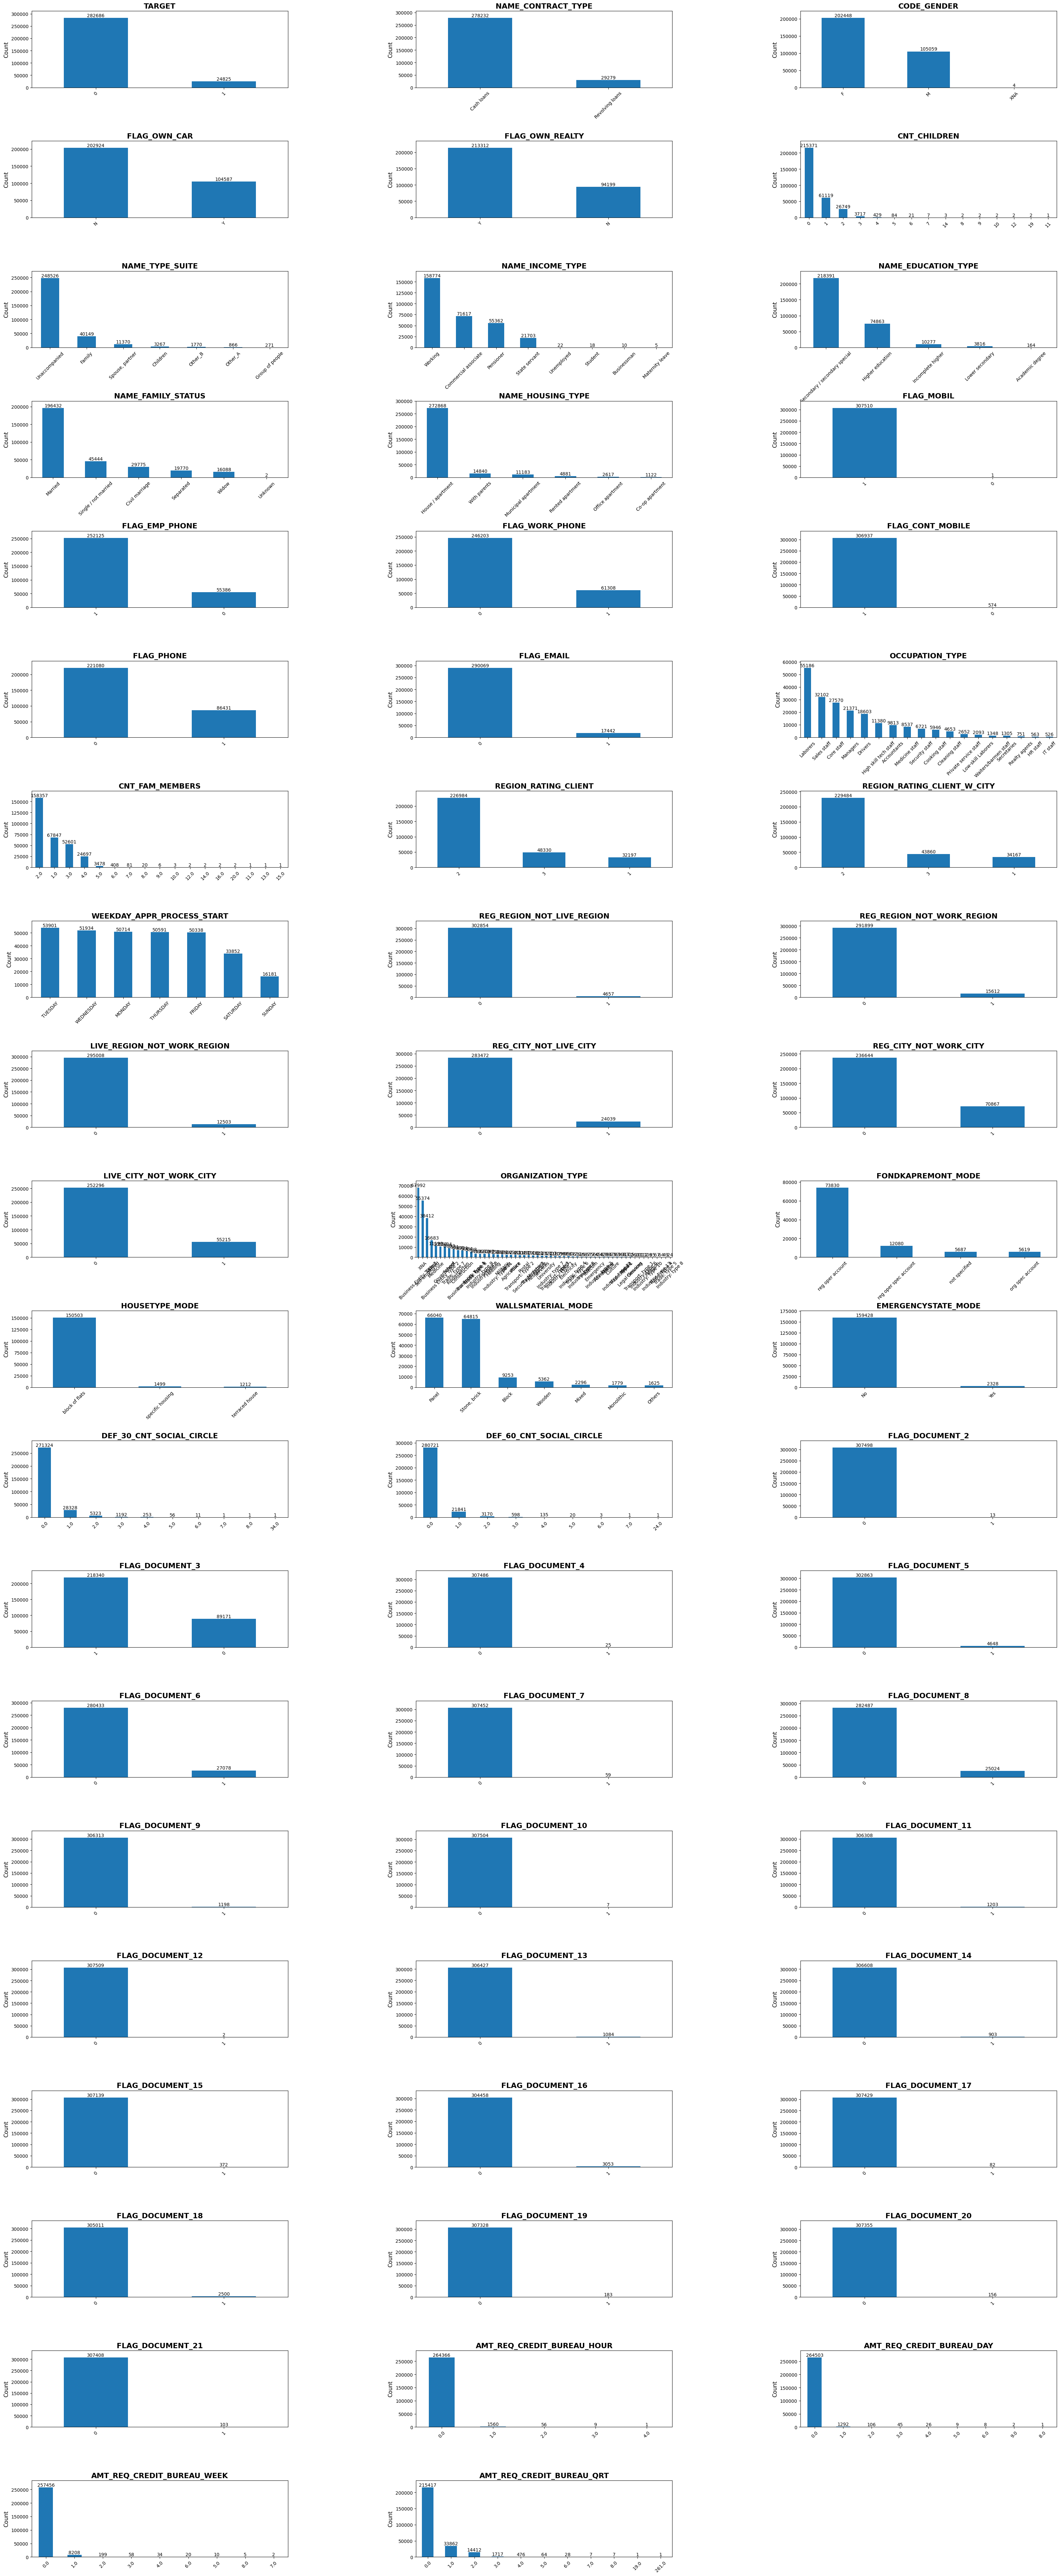

In [22]:
plot_categorical_bars(app_train)

In [23]:
def plot_numeric_boxplots(df, max_cols=3, figsize=(40, 100)):
    """
    Plots boxplots for all numeric variables in the DataFrame.

    Parameters:
    - df: DataFrame containing the data
    - max_cols: Number of columns per row in the subplot grid
    - figsize: Overall figure size
    """
    num_cols = df.select_dtypes(include='number').columns
    n_cols = max_cols
    n_rows = (len(num_cols) + n_cols - 1) // n_cols

    plt.figure(figsize=figsize)

    for idx, col in enumerate(num_cols):
        plt.subplot(n_rows, n_cols, idx + 1)
        sns.boxplot(x=df[col], color='skyblue')
        plt.title(col, fontsize=14, fontweight='bold')
        plt.xlabel('Value', fontsize=12)
        plt.ylabel('')
        plt.xticks(fontsize=10)
        plt.yticks([])  

    plt.subplots_adjust(wspace=0.5,hspace=1)
    plt.show()


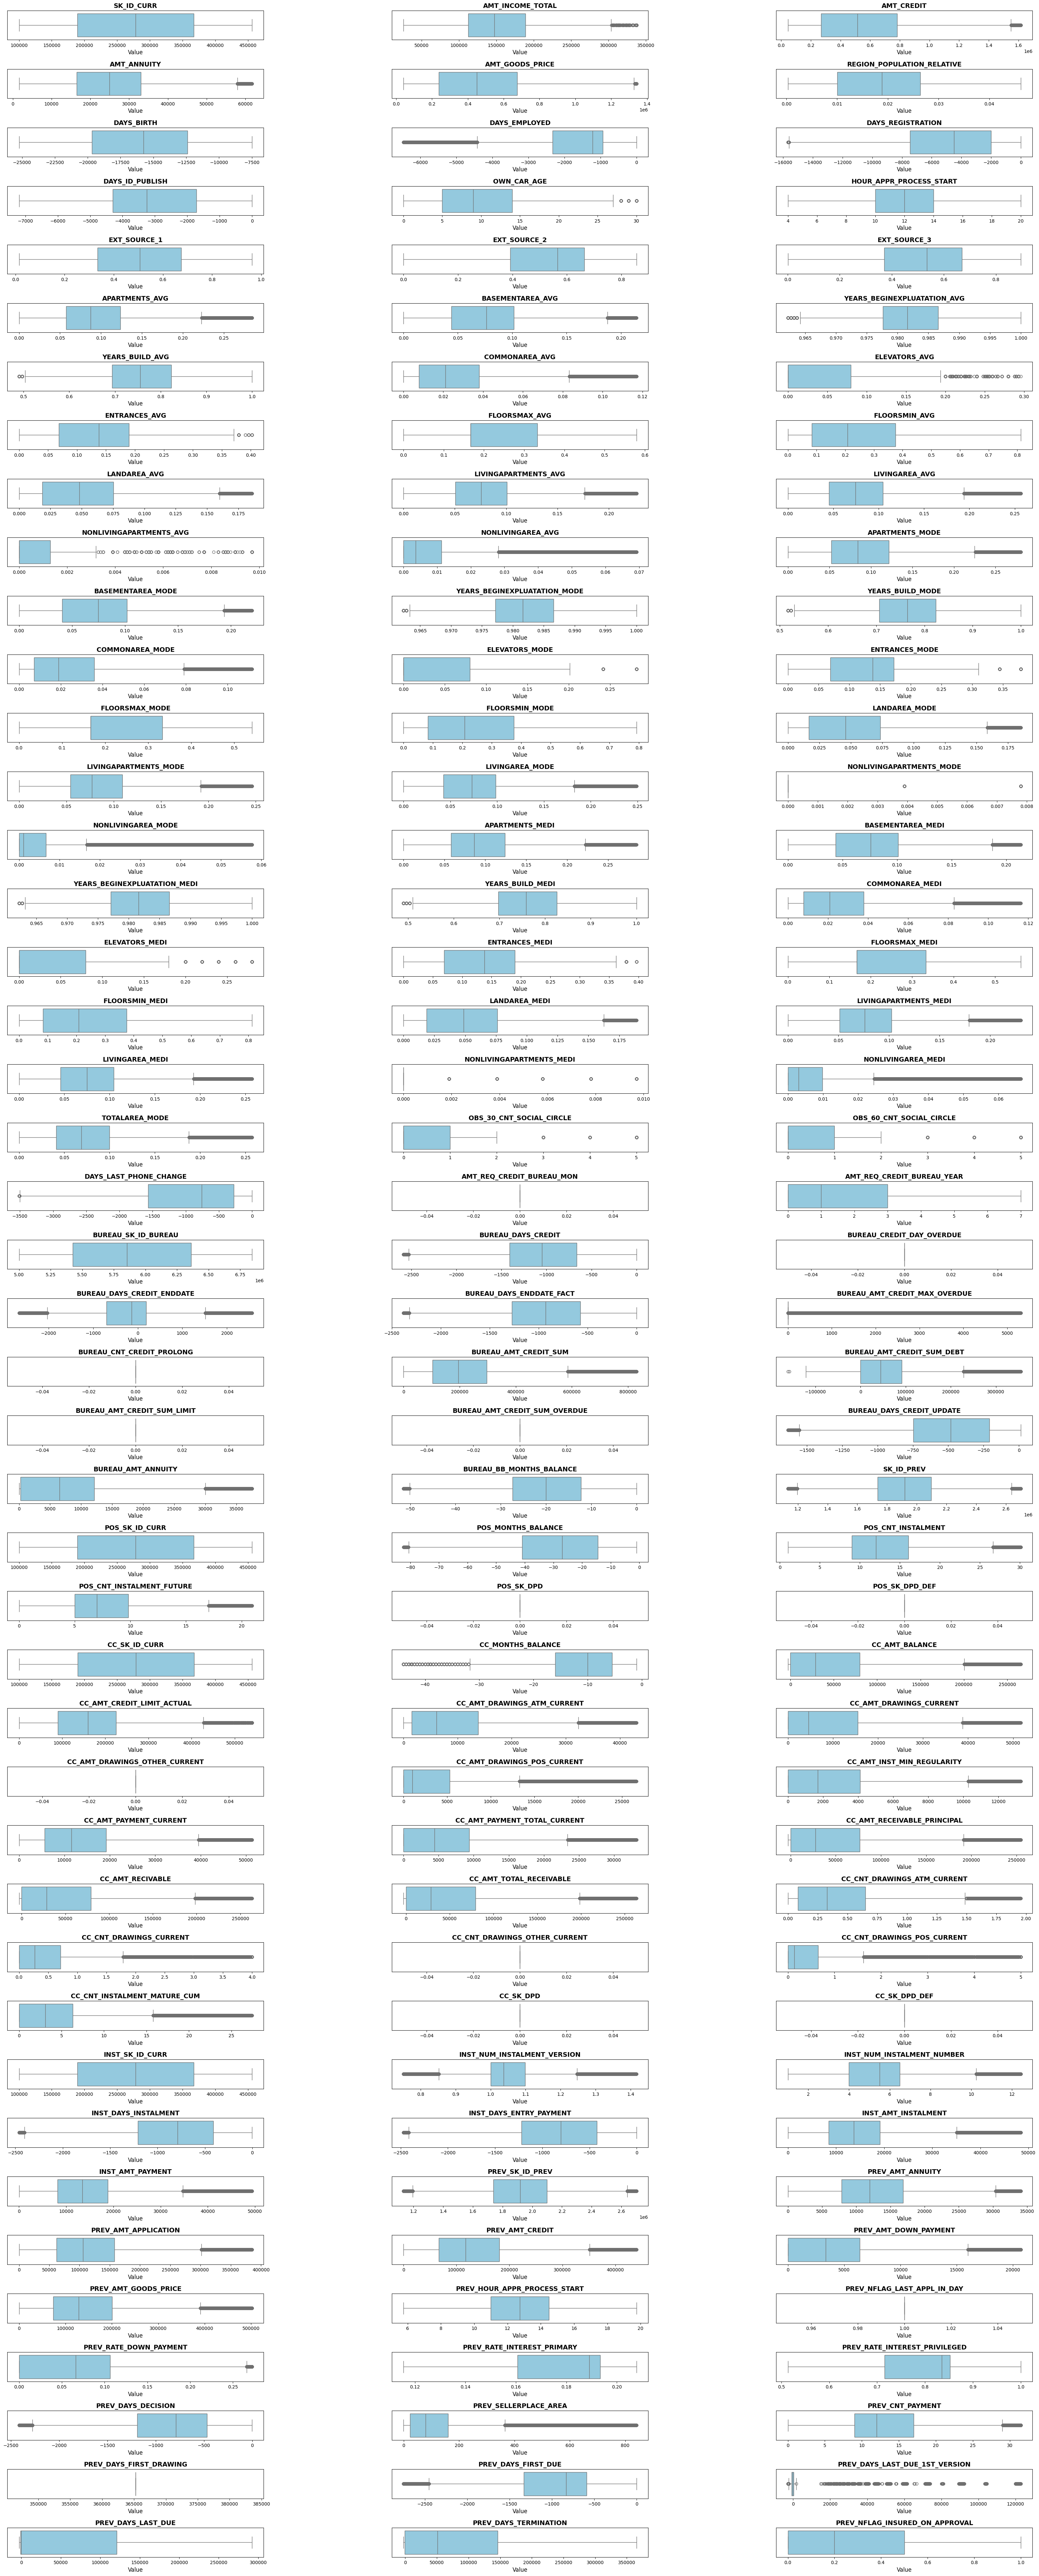

In [24]:
plot_numeric_boxplots(app_train)

# Standardization

In [25]:
standard_scaler = StandardScaler()

train_scaled = app_train.copy()
columns = train_scaled.select_dtypes(include='number').columns
columns = columns[columns != 'SK_ID_CURR']  # Exclude 'id'

for col in columns:
    train_scaled[col] = standard_scaler.fit_transform(np.array(train_scaled[col]).reshape(-1, 1))

train_scaled.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,BUREAU_SK_ID_BUREAU,BUREAU_DAYS_CREDIT,BUREAU_CREDIT_DAY_OVERDUE,BUREAU_DAYS_CREDIT_ENDDATE,BUREAU_DAYS_ENDDATE_FACT,BUREAU_AMT_CREDIT_MAX_OVERDUE,BUREAU_CNT_CREDIT_PROLONG,BUREAU_AMT_CREDIT_SUM,BUREAU_AMT_CREDIT_SUM_DEBT,BUREAU_AMT_CREDIT_SUM_LIMIT,BUREAU_AMT_CREDIT_SUM_OVERDUE,BUREAU_DAYS_CREDIT_UPDATE,BUREAU_AMT_ANNUITY,BUREAU_BB_MONTHS_BALANCE,SK_ID_PREV,POS_SK_ID_CURR,POS_MONTHS_BALANCE,POS_CNT_INSTALMENT,POS_CNT_INSTALMENT_FUTURE,POS_SK_DPD,POS_SK_DPD_DEF,CC_SK_ID_CURR,CC_MONTHS_BALANCE,CC_AMT_BALANCE,CC_AMT_CREDIT_LIMIT_ACTUAL,CC_AMT_DRAWINGS_ATM_CURRENT,CC_AMT_DRAWINGS_CURRENT,CC_AMT_DRAWINGS_OTHER_CURRENT,CC_AMT_DRAWINGS_POS_CURRENT,CC_AMT_INST_MIN_REGULARITY,CC_AMT_PAYMENT_CURRENT,CC_AMT_PAYMENT_TOTAL_CURRENT,CC_AMT_RECEIVABLE_PRINCIPAL,CC_AMT_RECIVABLE,CC_AMT_TOTAL_RECEIVABLE,CC_CNT_DRAWINGS_ATM_CURRENT,CC_CNT_DRAWINGS_CURRENT,CC_CNT_DRAWINGS_OTHER_CURRENT,CC_CNT_DRAWINGS_POS_CURRENT,CC_CNT_INSTALMENT_MATURE_CUM,CC_SK_DPD,CC_SK_DPD_DEF,INST_SK_ID_CURR,INST_NUM_INSTALMENT_VERSION,INST_NUM_INSTALMENT_NUMBER,INST_DAYS_INSTALMENT,INST_DAYS_ENTRY_PAYMENT,INST_AMT_INSTALMENT,INST_AMT_PAYMENT,PREV_SK_ID_PREV,PREV_AMT_ANNUITY,PREV_AMT_APPLICATION,PREV_AMT_CREDIT,PREV_AMT_DOWN_PAYMENT,PREV_AMT_GOODS_PRICE,PREV_HOUR_APPR_PROCESS_START,PREV_NFLAG_LAST_APPL_IN_DAY,PREV_RATE_DOWN_PAYMENT,PREV_RATE_INTEREST_PRIMARY,PREV_RATE_INTEREST_PRIVILEGED,PREV_DAYS_DECISION,PREV_SELLERPLACE_AREA,PREV_CNT_PAYMENT,PREV_DAYS_FIRST_DRAWING,PREV_DAYS_FIRST_DUE,PREV_DAYS_LAST_DUE_1ST_VERSION,PREV_DAYS_LAST_DUE,PREV_DAYS_TERMINATION,PREV_NFLAG_INSURED_ON_APPROVAL
0,100002,1,Cash loans,M,N,Y,0,0.776294,-0.464636,-0.099262,-0.473191,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,-0.055568,1.506880,0.828042,0.377010,0.579154,NaN,1,1,0,1,1,0,Laborer

# Train-Test Split

In [26]:
Y = train_scaled['TARGET']
X = train_scaled.drop(['TARGET'],axis=1)

In [27]:
X = X.fillna(X.select_dtypes(include=['number']).mean())

In [28]:
for col in X.select_dtypes(include=['number']).columns:
    X[col] = X[col].fillna(X[col].mean())

for col in X.select_dtypes(include=['object', 'category']).columns:
    if X[col].isnull().any():  
        X[col] = X[col].fillna(X[col].mode()[0])

In [29]:
cols_to_encode = X.select_dtypes(include=['category']).columns

for col in cols_to_encode:
    X[col] = pd.factorize(X[col])[0] + 1  

In [30]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X, Y,test_size=0.2, random_state = 42)

In [31]:
X_train=X_train.drop(['SK_ID_CURR'], axis=1) # to avoid data leakage
X_val=X_val.drop(['SK_ID_CURR'], axis=1) # to avoid data leakage

In [32]:
print (" Number of columns in our Features : ", X_train.shape[1])

 Number of columns in our Features :  189


# SMOTE + PCA

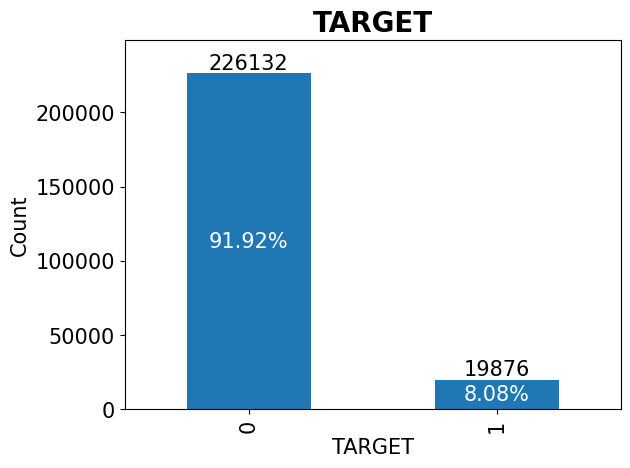

In [33]:
y_train.value_counts().plot(kind='bar')
plt.title("TARGET", fontsize=20, fontweight="bold")
plt.xlabel('TARGET', fontsize=15)
plt.ylabel('Count', fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

counts =y_train.value_counts()
for i, count in enumerate(counts):
    plt.text(i, count + 1, str(count), ha='center', va='bottom', fontsize=15)
    plt.text(i, count / 2, f"{round((count / len(y_train)) * 100, 2)}%", ha='center', va='center', fontsize=15, color='white')
    
plt.ylim(0, max(counts) * 1.1)  
plt.show()


In [34]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)
X_train_upsampled, y_train_upsampled = smote.fit_resample(X_train, y_train)

In [35]:
print("Before UpSampling, counts of Target = '0': {}".format(sum(y_train==0)))
print("Before UpSampling, counts of Target = '1': {} \n".format(sum(y_train==1)))


print("After UpSampling, counts of Target = '0': {}".format(sum(y_train_upsampled==0)))
print("After UpSampling, counts of Target = '1': {} \n".format(sum(y_train_upsampled==1)))

Before UpSampling, counts of Target = '0': 226132
Before UpSampling, counts of Target = '1': 19876 

After UpSampling, counts of Target = '0': 226132
After UpSampling, counts of Target = '1': 226132 



### PCA

In [36]:
from sklearn.decomposition import PCA

pca = PCA(n_components=0.95)  # Keep 95% variance
X_train_pca = pca.fit_transform(X_train_upsampled)

X_val_pca = pca.transform(X_val)

# Modelling

In [37]:
EVAL_SCORE = pd.DataFrame(columns=['Model','Accuracy','Precision','Recall' ,'F1 Score', 'AUC'])

EVAL_SCORE

,Model,Accuracy,Precision,Recall,F1 Score,AUC


## Random Forest

In [38]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(max_depth=2, random_state=0)

clf.fit(X_train_upsampled, y_train_upsampled)

RandomForestClassifier(max_depth=2, random_state=0)

In [39]:
y_pred_train_rf = clf.predict(X_train_upsampled)
y_pred_test_rf = clf.predict(X_val)

In [40]:
train_accuracy = accuracy_score(y_train_upsampled, y_pred_train_rf)
print("Random Forest Training Accuracy :" ,round(train_accuracy,3)*100)

test_accuracy = accuracy_score(y_val, y_pred_test_rf)
print("Random Forest Testing Accuracy :" ,round(test_accuracy,3)*100)

Random Forest Training Accuracy : 78.5
Random Forest Testing Accuracy : 71.1


In [41]:
conf_matrix = confusion_matrix(y_val, y_pred_test_rf)

# Add labels for better understanding
tn, fp, fn, tp = conf_matrix.ravel()
display( pd.DataFrame(conf_matrix, columns=['Predicted Negative', 'Predicted Positive'], index=['Actual Negative', 'Actual Positive']))

,Predicted Negative,Predicted Positive
Actual Negative,41413,15141
Actual Positive,2643,2306


In [42]:
print("Classification Report : \n" ,classification_report(y_val, y_pred_test_rf))

Classification Report : 
               precision    recall  f1-score   support

           0       0.94      0.73      0.82     56554
           1       0.13      0.47      0.21      4949

    accuracy                           0.71     61503
   macro avg       0.54      0.60      0.51     61503
weighted avg       0.88      0.71      0.77     61503



In [43]:
accuracy = accuracy_score(y_val, y_pred_test_rf)
precision = precision_score(y_val, y_pred_test_rf, average='macro')
recall = recall_score(y_val, y_pred_test_rf, average='macro')
f1_score= metrics.f1_score(y_val, y_pred_test_rf, average='macro')
auc= roc_auc_score(y_val, clf.predict_proba(X_val)[:,1])

new=pd.Series({'Model': 'Random Forest','Accuracy':accuracy,'Precision':precision,'Recall':recall, 'F1 Score': f1_score, 
               'AUC': auc})
EVAL_SCORE=pd.concat([EVAL_SCORE,new.to_frame().T], ignore_index=True)
EVAL_SCORE

,Model,Accuracy,Precision,Recall,F1 Score,AUC
0,Random Forest,0.710843,0.53609,0.599113,0.514584,0.636226


#### With PCA

In [44]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(max_depth=2, random_state=0)

clf.fit(X_train_pca, y_train_upsampled)

RandomForestClassifier(max_depth=2, random_state=0)

In [45]:
y_pred_train_rf = clf.predict(X_train_pca)
y_pred_test_rf = clf.predict(X_val_pca)

In [46]:
train_accuracy = accuracy_score(y_train_upsampled, y_pred_train_rf)
print("Random Forest Training Accuracy :" ,round(train_accuracy,3)*100)

test_accuracy = accuracy_score(y_val, y_pred_test_rf)
print("Random Forest Testing Accuracy :" ,round(test_accuracy,3)*100)

Random Forest Training Accuracy : 69.19999999999999
Random Forest Testing Accuracy : 67.4


In [47]:
conf_matrix = confusion_matrix(y_val, y_pred_test_rf)

# Add labels for better understanding
tn, fp, fn, tp = conf_matrix.ravel()
display( pd.DataFrame(conf_matrix, columns=['Predicted Negative', 'Predicted Positive'], index=['Actual Negative', 'Actual Positive']))

,Predicted Negative,Predicted Positive
Actual Negative,38989,17565
Actual Positive,2502,2447


In [48]:
accuracy = accuracy_score(y_val, y_pred_test_rf)
precision = precision_score(y_val, y_pred_test_rf, average='macro')
recall = recall_score(y_val, y_pred_test_rf, average='macro')
f1_score= metrics.f1_score(y_val, y_pred_test_rf, average='macro')
auc= roc_auc_score(y_val, clf.predict_proba(X_val_pca)[:,1])

new=pd.Series({'Model': 'Random Forest + PCA','Accuracy':accuracy,'Precision':precision,'Recall':recall, 'F1 Score': f1_score, 
               'AUC': auc})
EVAL_SCORE=pd.concat([EVAL_SCORE,new.to_frame().T], ignore_index=True)
EVAL_SCORE

,Model,Accuracy,Precision,Recall,F1 Score,AUC
0,Random Forest,0.710843,0.53609,0.599113,0.514584,0.636226
1,Random Forest + PCA,0.673723,0.530987,0.591928,0.495697,0.632166


# Logistic Regression

In [49]:
from sklearn.linear_model import LogisticRegression
logistic_model=LogisticRegression()
logistic_model.fit(X_train_upsampled,y_train_upsampled)

c:\Users\sama amr\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [50]:
y_pred_log=logistic_model.predict(X_val)

y_pred_train_log=logistic_model.predict(X_train_upsampled)

In [51]:
conf_matrix = confusion_matrix(y_val, y_pred_log)

# Add labels for better understanding
tn, fp, fn, tp = conf_matrix.ravel()
display( pd.DataFrame(conf_matrix, columns=['Predicted Negative', 'Predicted Positive'], index=['Actual Negative', 'Actual Positive']))

,Predicted Negative,Predicted Positive
Actual Negative,46334,10220
Actual Positive,3060,1889


In [52]:
print("Classification Report : \n" ,classification_report(y_val, y_pred_log))

Classification Report : 
               precision    recall  f1-score   support

           0       0.94      0.82      0.87     56554
           1       0.16      0.38      0.22      4949

    accuracy                           0.78     61503
   macro avg       0.55      0.60      0.55     61503
weighted avg       0.88      0.78      0.82     61503



In [53]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

print(f"Logistic Regression training Accuracy score: {accuracy_score(y_train_upsampled,y_pred_train_log)*100:.1f}")

print(f"Logistic Regression testing Accuracy score: {accuracy_score(y_val,y_pred_log)*100:.1f}")

Logistic Regression training Accuracy score: 82.6
Logistic Regression testing Accuracy score: 78.4


In [54]:
accuracy = accuracy_score(y_val, y_pred_log)
precision = precision_score(y_val, y_pred_log, average='macro')
recall = recall_score(y_val, y_pred_log, average='macro')
f1_score= metrics.f1_score(y_val, y_pred_log, average='macro')
auc= roc_auc_score(y_val, logistic_model.predict_proba(X_val)[:,1])

new=pd.Series({'Model': 'Logistic Regression','Accuracy':accuracy,'Precision':precision,'Recall':recall, 'F1 Score': f1_score, 
               'AUC': auc})
EVAL_SCORE=pd.concat([EVAL_SCORE,new.to_frame().T], ignore_index=True)
EVAL_SCORE

,Model,Accuracy,Precision,Recall,F1 Score,AUC
0,Random Forest,0.710843,0.53609,0.599113,0.514584,0.636226
1,Random Forest + PCA,0.673723,0.530987,0.591928,0.495697,0.632166
2,Logistic Regression,0.784076,0.547024,0.600491,0.548068,0.660783


# XG-BOOST

In [55]:
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, roc_auc_score

# Initialize XGBoost with key parameters
xgb_model = XGBClassifier(
    n_estimators=200,
    max_depth=5,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    eval_metric='logloss',
    random_state=42,
    early_stopping_rounds=10  # Requires eval_set
)

In [56]:
xgb_model.fit(
    X_train_upsampled, y_train_upsampled,
    eval_set=[(X_val, y_val)],
    verbose=10  
)

[0]	validation_0-logloss:0.66904
[10]	validation_0-logloss:0.50565
[20]	validation_0-logloss:0.43468
[30]	validation_0-logloss:0.39244
[40]	validation_0-logloss:0.35890
[50]	validation_0-logloss:0.34213
[60]	validation_0-logloss:0.32248
[70]	validation_0-logloss:0.30829
[80]	validation_0-logloss:0.29757
[90]	validation_0-logloss:0.28969
[100]	validation_0-logloss:0.28510
[110]	validation_0-logloss:0.28055
[120]	validation_0-logloss:0.27757
[130]	validation_0-logloss:0.27465
[140]	validation_0-logloss:0.27231
[150]	validation_0-logloss:0.26900
[160]	validation_0-logloss:0.26752
[170]	validation_0-logloss:0.26619
[180]	validation_0-logloss:0.26476
[190]	validation_0-logloss:0.26329
[199]	validation_0-logloss:0.26220


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=10,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=5,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=200,
              n_jobs=None, num_parallel_tree=None, random_state=42, ...)

In [57]:
y_pred_train = xgb_model.predict(X_train_upsampled)
y_pred_val = xgb_model.predict(X_val)
y_proba = xgb_model.predict_proba(X_val)[:, 1]

In [58]:
# Evaluation
print("Classification Report:")
print(classification_report(y_val, y_pred_val))
print(f"AUC-ROC: {roc_auc_score(y_val, y_proba):.4f}")

Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.99      0.95     56554
           1       0.30      0.06      0.09      4949

    accuracy                           0.91     61503
   macro avg       0.61      0.52      0.52     61503
weighted avg       0.87      0.91      0.89     61503

AUC-ROC: 0.7271


In [59]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

print(f"XG-Boost training Accuracy score: {accuracy_score(y_train_upsampled,y_pred_train)*100:.1f}")

print(f"XG-Boost testing Accuracy score: {accuracy_score(y_val,y_pred_val)*100:.1f}")

XG-Boost training Accuracy score: 95.2
XG-Boost testing Accuracy score: 91.3


In [60]:
accuracy = accuracy_score(y_val, y_pred_val)
precision = precision_score(y_val, y_pred_val, average='macro')
recall = recall_score(y_val, y_pred_val, average='macro')
f1_score= metrics.f1_score(y_val, y_pred_val, average='macro')
auc= roc_auc_score(y_val, y_proba)

new=pd.Series({'Model': 'XG-Boost','Accuracy':accuracy,'Precision':precision,'Recall':recall, 'F1 Score': f1_score, 
               'AUC': auc})
EVAL_SCORE=pd.concat([EVAL_SCORE,new.to_frame().T], ignore_index=True)
EVAL_SCORE

,Model,Accuracy,Precision,Recall,F1 Score,AUC
0,Random Forest,0.710843,0.53609,0.599113,0.514584,0.636226
1,Random Forest + PCA,0.673723,0.530987,0.591928,0.495697,0.632166
2,Logistic Regression,0.784076,0.547024,0.600491,0.548068,0.660783
3,XG-Boost,0.913435,0.609616,0.521852,0.523782,0.72705


#### Finding the optimal threshold

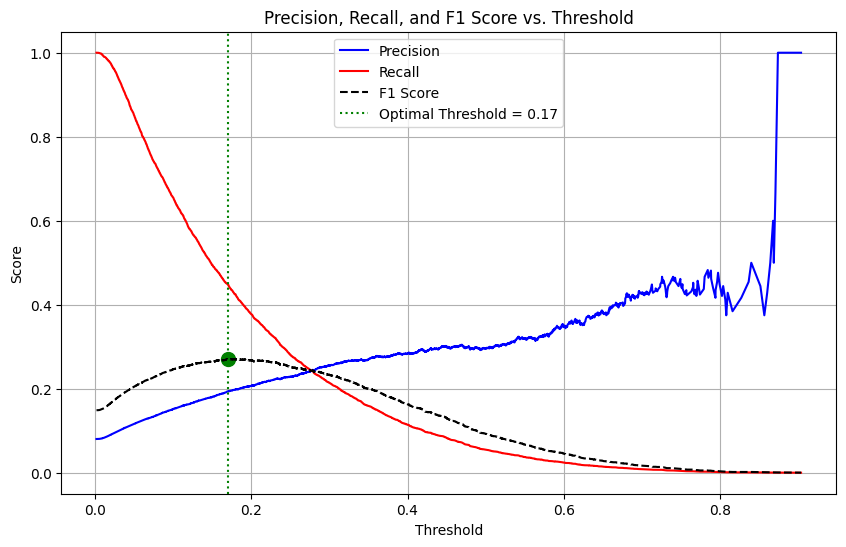


Classification Report at Optimal Threshold:
              precision    recall  f1-score   support

           0       0.95      0.84      0.89     56554
           1       0.19      0.45      0.27      4949

    accuracy                           0.81     61503
   macro avg       0.57      0.64      0.58     61503
weighted avg       0.89      0.81      0.84     61503



In [61]:
from sklearn.metrics import precision_recall_curve, f1_score

precision, recall, thresholds = precision_recall_curve(y_val, y_proba)

f1_scores = 2 * (precision * recall) / (precision + recall + 1e-9)  # Avoid division by zero
optimal_idx = np.argmax(f1_scores)
optimal_threshold = thresholds[optimal_idx]

plt.figure(figsize=(10, 6))
plt.plot(thresholds, precision[:-1], label="Precision", color="blue")
plt.plot(thresholds, recall[:-1], label="Recall", color="red")
plt.plot(thresholds, f1_scores[:-1], label="F1 Score", color="black", linestyle="--")

# optimal threshold
plt.axvline(x=optimal_threshold, color="green", linestyle=":", 
            label=f"Optimal Threshold = {optimal_threshold:.2f}")
plt.scatter(optimal_threshold, f1_scores[optimal_idx], color="green", s=100)

plt.xlabel("Threshold")
plt.ylabel("Score")
plt.title("Precision, Recall, and F1 Score vs. Threshold")
plt.legend()
plt.grid()
plt.show()

y_pred_optimal = (y_proba >= optimal_threshold).astype(int)
print("\nClassification Report at Optimal Threshold:")
print(classification_report(y_val, y_pred_optimal))

In [62]:
accuracy = accuracy_score(y_val, y_pred_optimal)
precision = precision_score(y_val, y_pred_optimal, average='macro')
recall = recall_score(y_val, y_pred_optimal, average='macro')
f1_score= metrics.f1_score(y_val, y_pred_optimal, average='macro')
auc= roc_auc_score(y_val, y_proba)

new=pd.Series({'Model': 'XG-Boost + Optimal Threshold','Accuracy':accuracy,'Precision':precision,'Recall':recall, 'F1 Score': f1_score, 
               'AUC': auc})
EVAL_SCORE=pd.concat([EVAL_SCORE,new.to_frame().T], ignore_index=True)
EVAL_SCORE

,Model,Accuracy,Precision,Recall,F1 Score,AUC
0,Random Forest,0.710843,0.53609,0.599113,0.514584,0.636226
1,Random Forest + PCA,0.673723,0.530987,0.591928,0.495697,0.632166
2,Logistic Regression,0.784076,0.547024,0.600491,0.548068,0.660783
3,XG-Boost,0.913435,0.609616,0.521852,0.523782,0.72705
4,XG-Boost + Optimal Threshold,0.805993,0.56989,0.642831,0.579606,0.72705


Save the model in joblib file

In [63]:
from joblib import dump
dump(xgb_model, 'xgb_model.joblib')

['xgb_model.joblib']

Get Feature Importance

In [64]:
importance = xgb_model.get_booster().get_score(importance_type='gain')  # or 'weight', 'cover', etc.
feature_names = list(importance.keys())

importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': list(importance.values())
}).sort_values(by='importance', ascending=False)

importance_df

,feature,importance
11,NAME_EDUCATION_TYPE,1646.432129
89,FLAG_DOCUMENT_3,1372.401489
102,BUREAU_AMT_CREDIT_MAX_OVERDUE,1276.175293
57,ELEVATORS_MODE,1192.462646
2,FLAG_OWN_CAR,1150.399414
...,...,...
76,LIVINGAPARTMENTS_MEDI,10.876619
67,BASEMENTAREA_MEDI,10.821747
69,YEARS_BUILD_MEDI,8.308564
137,PREV_SK_ID_PREV,7.702457


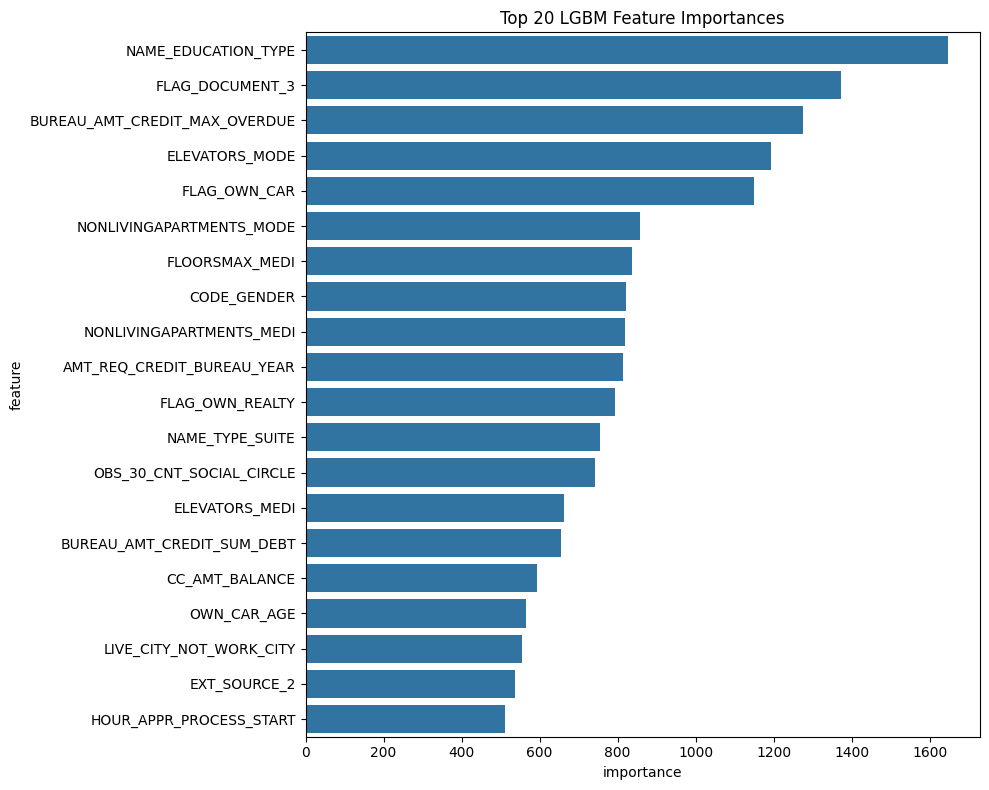

In [65]:
plt.figure(figsize=(10, 8))
sns.barplot(data=importance_df.head(20), x='importance', y='feature')
plt.title("Top 20 LGBM Feature Importances")
plt.tight_layout()
plt.show()

#### XG-Boost + PCA

In [66]:
xgb_model.fit(
    X_train_pca, y_train_upsampled,
    eval_set=[(X_val_pca, y_val)],
    verbose=10  
)

[0]	validation_0-logloss:0.67921
[10]	validation_0-logloss:0.61012
[20]	validation_0-logloss:0.57683
[30]	validation_0-logloss:0.55443
[40]	validation_0-logloss:0.53922
[50]	validation_0-logloss:0.52734
[60]	validation_0-logloss:0.51781
[70]	validation_0-logloss:0.51047
[80]	validation_0-logloss:0.50413
[90]	validation_0-logloss:0.49898
[100]	validation_0-logloss:0.49450
[110]	validation_0-logloss:0.49083
[120]	validation_0-logloss:0.48773
[130]	validation_0-logloss:0.48446
[140]	validation_0-logloss:0.48175
[150]	validation_0-logloss:0.47901
[160]	validation_0-logloss:0.47690
[170]	validation_0-logloss:0.47495
[180]	validation_0-logloss:0.47265
[190]	validation_0-logloss:0.47084
[199]	validation_0-logloss:0.46927


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=10,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=5,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=200,
              n_jobs=None, num_parallel_tree=None, random_state=42, ...)

In [67]:
y_pred_train = xgb_model.predict(X_train_pca)
y_pred_val = xgb_model.predict(X_val_pca)
y_proba = xgb_model.predict_proba(X_val_pca)[:, 1]

In [68]:
print("Classification Report:")
print(classification_report(y_val, y_pred_val))
print(f"AUC-ROC: {roc_auc_score(y_val, y_proba):.4f}")

Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.81      0.87     56554
           1       0.16      0.42      0.23      4949

    accuracy                           0.78     61503
   macro avg       0.55      0.61      0.55     61503
weighted avg       0.88      0.78      0.82     61503

AUC-ROC: 0.6794


In [69]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

print(f"XG-Boost + PCA training Accuracy score: {accuracy_score(y_train_upsampled,y_pred_train)*100:.1f}")

print(f"XG-Boost + PCA testing Accuracy score: {accuracy_score(y_val,y_pred_val)*100:.1f}")

XG-Boost + PCA training Accuracy score: 82.5
XG-Boost + PCA testing Accuracy score: 77.9


In [70]:
accuracy = accuracy_score(y_val, y_pred_val)
precision = precision_score(y_val, y_pred_val, average='macro')
recall = recall_score(y_val, y_pred_val, average='macro')
f1_score= metrics.f1_score(y_val, y_pred_val, average='macro')
auc= roc_auc_score(y_val, y_proba)

new=pd.Series({'Model': 'XG-Boost + PCA','Accuracy':accuracy,'Precision':precision,'Recall':recall, 'F1 Score': f1_score, 
               'AUC': auc})
EVAL_SCORE=pd.concat([EVAL_SCORE,new.to_frame().T], ignore_index=True)
EVAL_SCORE

,Model,Accuracy,Precision,Recall,F1 Score,AUC
0,Random Forest,0.710843,0.53609,0.599113,0.514584,0.636226
1,Random Forest + PCA,0.673723,0.530987,0.591928,0.495697,0.632166
2,Logistic Regression,0.784076,0.547024,0.600491,0.548068,0.660783
3,XG-Boost,0.913435,0.609616,0.521852,0.523782,0.72705
4,XG-Boost + Optimal Threshold,0.805993,0.56989,0.642831,0.579606,0.72705
5,XG-Boost + PCA,0.778531,0.551326,0.614439,0.551962,0.679374


## LGBM

In [71]:
from lightgbm import LGBMClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

lgbm = LGBMClassifier(
    objective='binary',
    boosting_type='gbdt',
    n_estimators=100,
    learning_rate=0.1,
    max_depth=-1,
    random_state=42
)

c:\Users\sama amr\AppData\Local\Programs\Python\Python39\lib\site-packages\dask\dataframe\__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


In [72]:
LGBM_model = lgbm.fit(X_train_upsampled, y_train_upsampled)

[LightGBM] [Info] Number of positive: 226132, number of negative: 226132
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.447843 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 30231
[LightGBM] [Info] Number of data points in the train set: 452264, number of used features: 172
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


In [73]:
y_pred_train = LGBM_model.predict(X_train_upsampled)
y_pred_val = LGBM_model.predict(X_val)
y_proba = LGBM_model.predict_proba(X_val)[:, 1]

In [74]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

print(f"LGBM training Accuracy score: {accuracy_score(y_train_upsampled,y_pred_train)*100:.1f}")

print(f"LGBM testing Accuracy score: {accuracy_score(y_val,y_pred_val)*100:.1f}")

LGBM training Accuracy score: 95.3
LGBM testing Accuracy score: 91.5


In [75]:
accuracy = accuracy_score(y_val, y_pred_val)
precision = precision_score(y_val, y_pred_val, average='macro')
recall = recall_score(y_val, y_pred_val, average='macro')
f1_score= metrics.f1_score(y_val, y_pred_val, average='macro')
auc= roc_auc_score(y_val, y_proba)

new=pd.Series({'Model': 'LGBM','Accuracy':accuracy,'Precision':precision,'Recall':recall, 'F1 Score': f1_score, 
               'AUC': auc})
EVAL_SCORE=pd.concat([EVAL_SCORE,new.to_frame().T], ignore_index=True)
EVAL_SCORE

,Model,Accuracy,Precision,Recall,F1 Score,AUC
0,Random Forest,0.710843,0.53609,0.599113,0.514584,0.636226
1,Random Forest + PCA,0.673723,0.530987,0.591928,0.495697,0.632166
2,Logistic Regression,0.784076,0.547024,0.600491,0.548068,0.660783
3,XG-Boost,0.913435,0.609616,0.521852,0.523782,0.72705
4,XG-Boost + Optimal Threshold,0.805993,0.56989,0.642831,0.579606,0.72705
5,XG-Boost + PCA,0.778531,0.551326,0.614439,0.551962,0.679374
6,LGBM,0.914752,0.611233,0.517775,0.51653,0.732789


#### Finding the optimal threshold

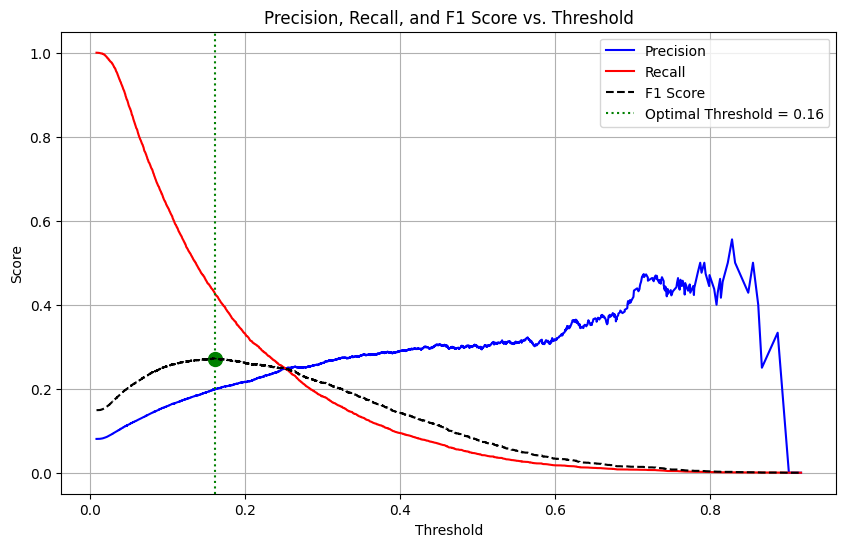


Classification Report at Optimal Threshold:
              precision    recall  f1-score   support

           0       0.94      0.85      0.89     56554
           1       0.20      0.43      0.27      4949

    accuracy                           0.81     61503
   macro avg       0.57      0.64      0.58     61503
weighted avg       0.88      0.81      0.84     61503



In [76]:
precision, recall, thresholds = precision_recall_curve(y_val, y_proba)

f1_scores = 2 * (precision * recall) / (precision + recall + 1e-9)  # Avoid division by zero
optimal_idx = np.argmax(f1_scores)
optimal_threshold = thresholds[optimal_idx]

plt.figure(figsize=(10, 6))
plt.plot(thresholds, precision[:-1], label="Precision", color="blue")
plt.plot(thresholds, recall[:-1], label="Recall", color="red")
plt.plot(thresholds, f1_scores[:-1], label="F1 Score", color="black", linestyle="--")

# Optimal threshold
plt.axvline(x=optimal_threshold, color="green", linestyle=":", 
            label=f"Optimal Threshold = {optimal_threshold:.2f}")
plt.scatter(optimal_threshold, f1_scores[optimal_idx], color="green", s=100)

plt.xlabel("Threshold")
plt.ylabel("Score")
plt.title("Precision, Recall, and F1 Score vs. Threshold")
plt.legend()
plt.grid()
plt.show()

y_pred_optimal = (y_proba >= optimal_threshold).astype(int)
print("\nClassification Report at Optimal Threshold:")
print(classification_report(y_val, y_pred_optimal))

In [77]:
accuracy = accuracy_score(y_val, y_pred_optimal)
precision = precision_score(y_val, y_pred_optimal, average='macro')
recall = recall_score(y_val, y_pred_optimal, average='macro')
f1_score= metrics.f1_score(y_val, y_pred_optimal, average='macro')
auc= roc_auc_score(y_val, y_proba)

new=pd.Series({'Model': 'LGBM + Optimal threshold','Accuracy':accuracy,'Precision':precision,'Recall':recall, 'F1 Score': f1_score, 
               'AUC': auc})
EVAL_SCORE=pd.concat([EVAL_SCORE,new.to_frame().T], ignore_index=True)
EVAL_SCORE

,Model,Accuracy,Precision,Recall,F1 Score,AUC
0,Random Forest,0.710843,0.53609,0.599113,0.514584,0.636226
1,Random Forest + PCA,0.673723,0.530987,0.591928,0.495697,0.632166
2,Logistic Regression,0.784076,0.547024,0.600491,0.548068,0.660783
3,XG-Boost,0.913435,0.609616,0.521852,0.523782,0.72705
4,XG-Boost + Optimal Threshold,0.805993,0.56989,0.642831,0.579606,0.72705
5,XG-Boost + PCA,0.778531,0.551326,0.614439,0.551962,0.679374
6,LGBM,0.914752,0.611233,0.517775,0.51653,0.732789
7,LGBM + Optimal threshold,0.814692,0.571636,0.639172,0.582866,0.732789


Save the model in a joblib file

In [78]:
from joblib import dump
dump(LGBM_model, 'lgbm_model.joblib')

['lgbm_model.joblib']

Get Feature Importance

In [79]:
# Get feature importances and feature names
booster = LGBM_model.booster_
importance = booster.feature_importance(importance_type='gain')  # or 'split'
feature_names = booster.feature_name()

importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': importance
}).sort_values(by='importance', ascending=False)

importance_df

,feature,importance
125,BUREAU_AMT_CREDIT_MAX_OVERDUE,317966.871986
119,AMT_REQ_CREDIT_BUREAU_YEAR,316070.214731
31,HOUR_APPR_PROCESS_START,208832.387909
40,EXT_SOURCE_2,173504.327875
19,OWN_CAR_AGE,143358.166849
...,...,...
140,POS_SK_DPD_DEF,0.000000
139,POS_SK_DPD,0.000000
99,FLAG_DOCUMENT_7,0.000000
101,FLAG_DOCUMENT_9,0.000000


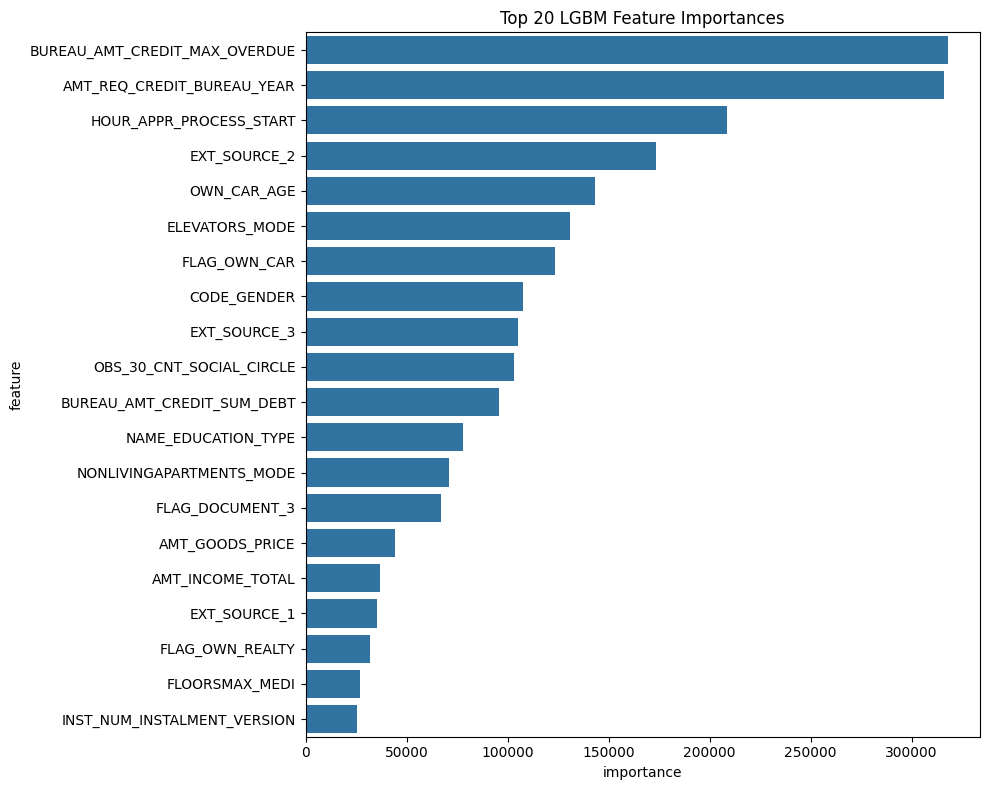

In [80]:
plt.figure(figsize=(10, 8))
sns.barplot(data=importance_df.head(20), x='importance', y='feature')
plt.title("Top 20 LGBM Feature Importances")
plt.tight_layout()
plt.show()


#### LGBM + PCA

In [81]:
lgbm = LGBMClassifier(
    objective='binary',
    boosting_type='gbdt',
    n_estimators=100,
    learning_rate=0.1,
    max_depth=-1,
    random_state=42
)

In [82]:
LGBM_model = lgbm.fit(X_train_pca, y_train_upsampled)

[LightGBM] [Info] Number of positive: 226132, number of negative: 226132
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.117935 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13260
[LightGBM] [Info] Number of data points in the train set: 452264, number of used features: 52
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


In [83]:
y_pred_train = LGBM_model.predict(X_train_pca)
y_pred_val = LGBM_model.predict(X_val_pca)

In [84]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

print(f"LGBM training Accuracy score: {accuracy_score(y_train_upsampled,y_pred_train)*100:.1f}")

print(f"LGBM testing Accuracy score: {accuracy_score(y_val,y_pred_val)*100:.1f}")

LGBM training Accuracy score: 81.3
LGBM testing Accuracy score: 78.8


In [85]:
accuracy = accuracy_score(y_val, y_pred_val)
precision = precision_score(y_val, y_pred_val, average='macro')
recall = recall_score(y_val, y_pred_val, average='macro')
f1_score= metrics.f1_score(y_val, y_pred_val, average='macro')
auc= roc_auc_score(y_val, y_proba)

new=pd.Series({'Model': 'LGBM + PCA','Accuracy':accuracy,'Precision':precision,'Recall':recall, 'F1 Score': f1_score, 
               'AUC': auc})
EVAL_SCORE=pd.concat([EVAL_SCORE,new.to_frame().T], ignore_index=True)
EVAL_SCORE

,Model,Accuracy,Precision,Recall,F1 Score,AUC
0,Random Forest,0.710843,0.53609,0.599113,0.514584,0.636226
1,Random Forest + PCA,0.673723,0.530987,0.591928,0.495697,0.632166
2,Logistic Regression,0.784076,0.547024,0.600491,0.548068,0.660783
3,XG-Boost,0.913435,0.609616,0.521852,0.523782,0.72705
4,XG-Boost + Optimal Threshold,0.805993,0.56989,0.642831,0.579606,0.72705
5,XG-Boost + PCA,0.778531,0.551326,0.614439,0.551962,0.679374
6,LGBM,0.914752,0.611233,0.517775,0.51653,0.732789
7,LGBM + Optimal threshold,0.814692,0.571636,0.639172,0.582866,0.732789
8,LGBM + PCA,0.788336,0.550743,0.607324,0.553374,0.732789


#### Eval sorted

In [86]:
EVAL_SCORE.sort_values(by='F1 Score', inplace = True, ascending= False)
EVAL_SCORE

,Model,Accuracy,Precision,Recall,F1 Score,AUC
7,LGBM + Optimal threshold,0.814692,0.571636,0.639172,0.582866,0.732789
4,XG-Boost + Optimal Threshold,0.805993,0.56989,0.642831,0.579606,0.72705
8,LGBM + PCA,0.788336,0.550743,0.607324,0.553374,0.732789
5,XG-Boost + PCA,0.778531,0.551326,0.614439,0.551962,0.679374
2,Logistic Regression,0.784076,0.547024,0.600491,0.548068,0.660783
3,XG-Boost,0.913435,0.609616,0.521852,0.523782,0.72705
6,LGBM,0.914752,0.611233,0.517775,0.51653,0.732789
0,Random Forest,0.710843,0.53609,0.599113,0.514584,0.636226
1,Random Forest + PCA,0.673723,0.530987,0.591928,0.495697,0.632166


# Test Data

In [113]:
app_test = process_and_merge_data(app_test, bureau, bureau_balance, POS, credit_card, installments, previous)
save_to_parquet(app_test, "merged_application_test_mean.parquet")

Parquet file saved to: merged_application_test_mean.parquet
Merging completed. Final shape: (48744, 190)


In [114]:
# Type Transformations
cat = []

for col in app_test.select_dtypes(include=['int', 'float']).columns:
    unique_vals = app_test[col].nunique()
    if unique_vals < 20:  # Threshold 
        print(f"{col}: {unique_vals} unique values --> Likely categorical")
        cat.append(col)  # Add column name to the list

app_test[cat] = app_test[cat].astype('category')

cat2 = app_test.select_dtypes(include='object')

for col in cat2.columns:
    app_test[col] = app_test[col].astype('category')

app_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48744 entries, 0 to 48743
Columns: 190 entries, SK_ID_CURR to PREV_NFLAG_INSURED_ON_APPROVAL
dtypes: category(60), float32(89), float64(36), int64(5)
memory usage: 34.6 MB


In [115]:
test_scaled = app_test.copy()

if 'SK_ID_CURR' in test_scaled.columns:
                sk_id_curr = test_scaled['SK_ID_CURR'].copy()
                test_scaled = test_scaled.drop(['SK_ID_CURR'], axis=1)

In [116]:
columns = test_scaled.select_dtypes(include='number').columns

for col in columns:
    test_scaled[col] = standard_scaler.fit_transform(np.array(test_scaled[col]).reshape(-1, 1))


In [117]:
# Replace outliers with median
numeric_train = test_scaled.select_dtypes(include='number').copy()

for col in numeric_train.columns:
    numeric_train[col] = replace_outliers_with_median(numeric_train[col])

test_scaled[numeric_train.columns] = numeric_train

In [118]:
# PCA
standard_scaler = StandardScaler()

columns = test_scaled.select_dtypes(include='number').columns

for col in columns:
    test_scaled[col] = standard_scaler.fit_transform(np.array(test_scaled[col]).reshape(-1,1))

In [119]:
# Encoding
cols_to_encode = test_scaled.select_dtypes(include=['category']).columns

for col in cols_to_encode:
    test_scaled[col] = pd.factorize(test_scaled[col])[0] + 1  

In [120]:
from joblib import load
loaded_model = load('lgbm_model.joblib')
y_pred = loaded_model.predict(test_scaled)

In [125]:
X = test_scaled.values

# This returns probability for each class
probas = loaded_model.predict_proba(X)

In [ ]:
submit = pd.DataFrame({
    'SK_ID_CURR': test_scaled['SK_ID_CURR'],
    'TARGET': test_scaled['Predicted_Probability']
})
submit
submit.to_csv('submission.csv', index=False)

,SK_ID_CURR,TARGET
0,100001,0.995332
1,100005,0.996658
2,100013,0.866003
3,100028,0.994349
4,100038,0.989864
...,...,...
48739,456221,0.978758
48740,456222,0.998651
48741,456223,0.978193
48742,456224,0.994131


In [135]:
submit.to_csv('submission.csv', index=False)

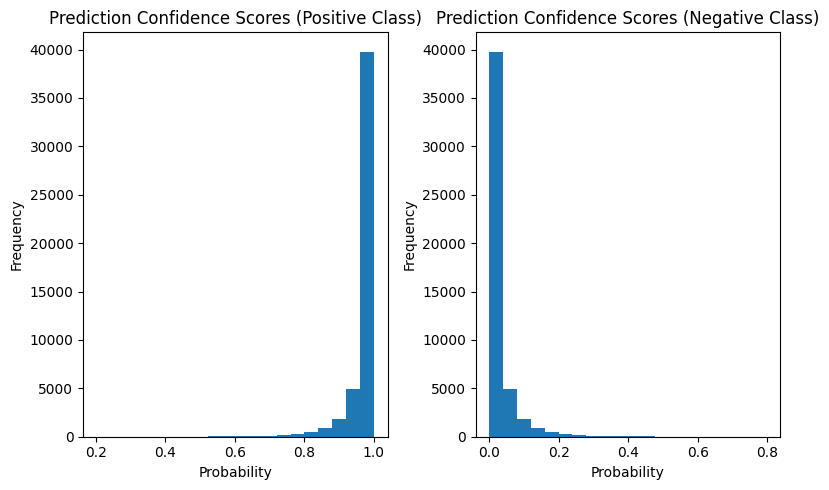

In [95]:
plt.figure(figsize=(8, 5)) 

plt.subplot(1, 2, 1)
y_proba = loaded_model.predict_proba(test_scaled)[:, 1]  # Probabilities for positive class
pd.Series(y_proba).plot(kind='hist', bins=20, title='Prediction Confidence Scores (Positive Class)')
plt.xlabel('Probability')

plt.subplot(1, 2, 2)
y_proba = loaded_model.predict_proba(test_scaled)[:, 0]  # Probabilities for negative class
pd.Series(y_proba).plot(kind='hist', bins=20, title='Prediction Confidence Scores (Negative Class)')
plt.xlabel('Probability')

plt.tight_layout()  
plt.show()

In [96]:
X = test_scaled.values
test_scaled['Predictions'] = loaded_model.predict(X)

C:\Users\sama amr\AppData\Local\Temp\ipykernel_22952\2048572104.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  test_scaled['Predictions'] = loaded_model.predict(X)


In [100]:
probas = loaded_model.predict_proba(X)
# Probability of TARGET = 1
test_scaled['Predicted_Probability'] = probas[:, 1]

C:\Users\sama amr\AppData\Local\Temp\ipykernel_22952\2028384708.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  test_scaled['Predicted_Probability'] = probas[:, 1]


In [ ]:
submit= test_scaled

Export the processed test file to excel csv

In [97]:
def save_to_csv(dataframe, filename):
    dataframe.to_csv(filename, index=False)
    print(f"Data saved to {filename}")

# Example usage
save_to_csv(test_scaled, "merged_application_test_scaled.csv")

Data saved to merged_application_test_scaled.csv


# GUI

## Tkinter Library

In [241]:
import tkinter as tk
from tkinter import ttk, filedialog, messagebox
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg, NavigationToolbar2Tk
from matplotlib.figure import Figure
import time
import os
from joblib import load

class CreditRiskApp:
    def __init__(self, root):
        self.root = root
        self.root.title("Credit Risk Analysis Dashboard")
        self.root.geometry("1200x800")
        
        # Initialize data storage
        self.raw_df = None
        self.processed_df = None
        self.test_scaled = None
        self.y_pred = None
        self.upload_time = 0
        self.processing_time = 0
        
        # Create UI components
        self.create_widgets()
        
    def create_widgets(self):
        # Create main container
        self.main_frame = ttk.Frame(self.root)
        self.main_frame.pack(fill=tk.BOTH, expand=True, padx=10, pady=10)
        
        # Title frame with dark grey background
        title_frame = tk.Frame(self.main_frame, bg='#333333')
        title_frame.pack(fill=tk.X, pady=(0,10))
        
        # Title label with dark grey background
        title_label = tk.Label(title_frame, 
                             text="Credit Risk Analysis", 
                             font=('Helvetica', 16, 'bold'),
                             bg='#333333',
                             fg='white')
        title_label.pack(pady=10)
        
        # Time display
        self.time_frame = ttk.Frame(self.main_frame)
        self.time_frame.pack(fill=tk.X, pady=5)
        
        self.time_label = ttk.Label(self.time_frame, text="Upload time: - | Processing time: - | Total time: -")
        self.time_label.pack()
        
        # Upload section
        upload_frame = ttk.LabelFrame(self.main_frame, text="Upload Data")
        upload_frame.pack(fill=tk.X, pady=10)
        
        self.upload_btn = ttk.Button(upload_frame, text="Select File", command=self.load_file)
        self.upload_btn.pack(pady=10)
        
        self.file_label = ttk.Label(upload_frame, text="No file selected")
        self.file_label.pack()
        
        # Tab control
        self.notebook = ttk.Notebook(self.main_frame)
        self.notebook.pack(fill=tk.BOTH, expand=True)
        
        # Visualization tab
        self.viz_tab = ttk.Frame(self.notebook)
        self.notebook.add(self.viz_tab, text="Visualizations")
        
        # Prediction tab
        self.pred_tab = ttk.Frame(self.notebook)
        self.notebook.add(self.pred_tab, text="Predictions")
        
        # Data preview tab
        self.data_tab = ttk.Frame(self.notebook)
        self.notebook.add(self.data_tab, text="Data Preview")
        
        # Initialize tabs
        self.init_viz_tab()
        self.init_pred_tab()
        self.init_data_tab()
        
    def load_file(self):
        file_path = filedialog.askopenfilename(
            filetypes=[("CSV Files", "*.csv"), ("Excel Files", "*.xls *.xlsx")]
        )
        
        if not file_path:
            return
            
        start_time = time.time()
        
        try:
            if file_path.endswith('.csv'):
                self.raw_df = pd.read_csv(file_path)
            else:
                self.raw_df = pd.read_excel(file_path)
                
            self.upload_time = time.time() - start_time
            self.file_label.config(text=f"Loaded: {os.path.basename(file_path)}")
            
            # Process data
            self.process_data() 
            
            # Update UI
            self.update_data_preview()
            self.update_filters()
            self.update_visualizations()
            self.update_prediction_graph()
            
        except Exception as e:
            messagebox.showerror("Error", f"Failed to load file: {str(e)}")
            
    def replace_outliers_with_median(self, series):
        """Replace outliers with median using IQR method"""
        Q1 = series.quantile(0.25)
        Q3 = series.quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        
        median = series.median()
        return series.apply(lambda x: median if (x < lower_bound) or (x > upper_bound) else x)
            
    def process_data(self):
        if self.raw_df is None:
            return
            
        start_time = time.time()
        
        try:
            test_scaled = self.raw_df.copy()
            test_scaled= process_and_merge_data(test_scaled, bureau, bureau_balance, POS, credit_card, installments, previous) 
            # Type Transformations
            cat = []
            for col in test_scaled.select_dtypes(include=['int', 'float']).columns:
                unique_vals = test_scaled[col].nunique()
                if unique_vals < 20:  # Threshold 
                    print(f"{col}: {unique_vals} unique values --> Likely categorical")
                    cat.append(col)

            test_scaled[cat] = test_scaled[cat].astype('category')

            # Convert object columns to category
            cat2 = test_scaled.select_dtypes(include='object')
            for col in cat2.columns:
                test_scaled[col] = test_scaled[col].astype('category')

            # Standard scaling for numeric features
            numeric_cols = test_scaled.select_dtypes(include='number').columns
            numeric_cols = numeric_cols[numeric_cols != 'SK_ID_CURR']  # Exclude ID column

            standard_scaler = StandardScaler()
            for col in numeric_cols:
                test_scaled[col] = standard_scaler.fit_transform(
                    np.array(test_scaled[col]).reshape(-1, 1))

            # Replace outliers with median
            numeric_train = test_scaled.select_dtypes(include='number').copy()
            for col in numeric_train.columns:
                numeric_train[col] = self.replace_outliers_with_median(numeric_train[col])

            test_scaled[numeric_train.columns] = numeric_train

            # Encoding categorical features
            cols_to_encode = test_scaled.select_dtypes(include=['category']).columns
            for col in cols_to_encode:
                test_scaled[col] = pd.factorize(test_scaled[col])[0] + 1

            # Store SK_ID_CURR before dropping
            if 'SK_ID_CURR' in test_scaled.columns:
                sk_id_curr = test_scaled['SK_ID_CURR'].copy()
                test_scaled = test_scaled.drop(['SK_ID_CURR'], axis=1)

            # Make predictions
            loaded_model = load('lgbm_model.joblib')
            y_pred = loaded_model.predict(test_scaled)

            # Store processed data
            self.processing_time = time.time() - start_time
            self.test_scaled = test_scaled
            self.y_pred = y_pred

            # Create a combined dataframe for visualization
            self.processed_df = self.raw_df.copy()
            self.processed_df['PREDICTION'] = y_pred

            # Update time display
            total_time = self.upload_time + self.processing_time
            time_text = f"Upload time: {self.format_time(self.upload_time)} | " \
                       f"Processing time: {self.format_time(self.processing_time)} | " \
                       f"Total time: {self.format_time(total_time)}"
            self.time_label.config(text=time_text)
            
        except Exception as e:
            messagebox.showerror("Error", f"Failed to process data: {str(e)}")
            print(f"Processing error: {str(e)}")
            
    def format_time(self, seconds):
        return f"{seconds:.2f}s"
        
    def update_data_preview(self):
        # Clear existing data
        for item in self.tree.get_children():
            self.tree.delete(item)
            
        if self.raw_df is None:
            return
            
        # Set up columns
        self.tree["columns"] = list(self.raw_df.columns)
        self.tree["show"] = "headings"
        
        # Add column headings
        for col in self.raw_df.columns:
            self.tree.heading(col, text=col)
            self.tree.column(col, width=100, anchor=tk.CENTER)
            
        # Add data rows (first 50 rows)
        for _, row in self.raw_df.head(50).iterrows():
            self.tree.insert("", tk.END, values=list(row))
            
    def update_filters(self):
        if self.processed_df is None:
            return
            
        # Update SK_ID_CURR filter
        if 'SK_ID_CURR' in self.processed_df.columns:
            sk_ids = sorted(self.processed_df['SK_ID_CURR'].unique())
            # Add "Show All" as the first option
            self.sk_id_combo['values'] = ["Show All"] + sk_ids
            # Set default to "Show All"
            self.sk_id_combo.current(0)
            
        # Update column selector
        columns = [col for col in self.processed_df.columns if col != 'PREDICTION']
        self.column_combo['values'] = columns
        if columns:
            self.column_combo.current(0)
            
    def update_visualizations(self):
        # Clear existing visualizations
        for widget in self.left_viz_frame.winfo_children():
            widget.destroy()
        for widget in self.right_viz_frame.winfo_children():
            widget.destroy()
            
        if self.processed_df is None:
            return
            
        # Get filtered data for other visualizations
        df = self.processed_df.copy()
        sk_id = self.sk_id_var.get()
        
        # Only filter if a specific SK_ID is selected (not "Show All")
        if sk_id and sk_id != "Show All" and 'SK_ID_CURR' in df.columns:
            try:
                df = df[df['SK_ID_CURR'] == int(sk_id)]
            except:
                pass
                
        # Create other visualizations
        selected_col = self.column_var.get()
        if not selected_col or selected_col not in df.columns:
            return
            
        is_numeric = pd.api.types.is_numeric_dtype(df[selected_col])
        
        if is_numeric:
            self.create_histogram(df, selected_col)
            self.create_boxplot(df, selected_col)
        else:
            self.create_pie_chart(df, selected_col)
            self.create_bar_chart(df, selected_col)

    def create_histogram(self, df, column):
        fig = Figure(figsize=(5, 4), dpi=100)
        ax = fig.add_subplot(111)
        df[column].plot.hist(ax=ax, bins=20, edgecolor='black')
        ax.set_title(f"Histogram of {column}")
        
        canvas = FigureCanvasTkAgg(fig, master=self.left_viz_frame)
        canvas.draw()
        canvas.get_tk_widget().pack(fill=tk.BOTH, expand=True)
        
        toolbar = NavigationToolbar2Tk(canvas, self.left_viz_frame)
        toolbar.update()

    def create_boxplot(self, df, column):
        fig = Figure(figsize=(5, 4), dpi=100)
        ax = fig.add_subplot(111)
        df[column].plot.box(ax=ax)
        ax.set_title(f"Boxplot of {column}")
        
        canvas = FigureCanvasTkAgg(fig, master=self.right_viz_frame)
        canvas.draw()
        canvas.get_tk_widget().pack(fill=tk.BOTH, expand=True)
        
        toolbar = NavigationToolbar2Tk(canvas, self.right_viz_frame)
        toolbar.update()

    def create_pie_chart(self, df, column):
        fig = Figure(figsize=(5, 4), dpi=100)
        ax = fig.add_subplot(111)
        df[column].value_counts().plot.pie(ax=ax, autopct='%1.1f%%')
        ax.set_title(f"Pie Chart of {column}")
        ax.set_ylabel('')  # Remove default 'None' label
        
        canvas = FigureCanvasTkAgg(fig, master=self.left_viz_frame)
        canvas.draw()
        canvas.get_tk_widget().pack(fill=tk.BOTH, expand=True)
        
        toolbar = NavigationToolbar2Tk(canvas, self.left_viz_frame)
        toolbar.update()

    def create_bar_chart(self, df, column):
        fig = Figure(figsize=(5, 4), dpi=100)
        ax = fig.add_subplot(111)
        df[column].value_counts().plot.bar(ax=ax, color='skyblue')
        ax.set_title(f"Bar Chart of {column}")
        
        canvas = FigureCanvasTkAgg(fig, master=self.right_viz_frame)
        canvas.draw()
        canvas.get_tk_widget().pack(fill=tk.BOTH, expand=True)
        
        toolbar = NavigationToolbar2Tk(canvas, self.right_viz_frame)
        toolbar.update()
            
    def update_prediction_graph(self):
        # Clear existing visualization
        for widget in self.pred_viz_frame.winfo_children():
            widget.destroy()
            
        if self.processed_df is None:
            return
            
        # Get filtered data
        df = self.processed_df.copy()
        sk_id = self.sk_id_var.get()
    
        # Only filter if a specific SK_ID is selected (not "Show All")
        if sk_id and sk_id != "Show All" and 'SK_ID_CURR' in df.columns:
            try:
                df = df[df['SK_ID_CURR'] == int(sk_id)]
            except:
                pass
                
        self.create_prediction_graph(df)
            
    def create_prediction_graph(self, df):
        """Create a bar graph showing the distribution of predictions"""
        if 'PREDICTION' not in df.columns:
            fig = Figure(figsize=(10, 4), dpi=100)
            ax = fig.add_subplot(111)
            ax.text(0.5, 0.5, 'No prediction data available', 
                   ha='center', va='center', fontsize=12)
            ax.axis('off')
        else:
            fig = Figure(figsize=(10, 4), dpi=100)
            ax = fig.add_subplot(111)
            
            pred_counts = df['PREDICTION'].value_counts().sort_index()
            colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']
            bars = ax.bar(pred_counts.index.astype(str), pred_counts.values, 
                         color=colors[:len(pred_counts)])
            
            for bar in bars:
                height = bar.get_height()
                ax.text(bar.get_x() + bar.get_width()/2., height,
                        f'{int(height)}',
                        ha='center', va='bottom')
            
            ax.set_title("Prediction Distribution", fontsize=12)
            ax.set_xlabel("Prediction Class", fontsize=10)
            ax.set_ylabel("Count", fontsize=10)
            ax.grid(axis='y', linestyle='--', alpha=0.7)
            ax.spines['top'].set_visible(False)
            ax.spines['right'].set_visible(False)
        
        canvas = FigureCanvasTkAgg(fig, master=self.pred_viz_frame)
        canvas.draw()
        canvas.get_tk_widget().pack(fill=tk.BOTH, expand=True, padx=10, pady=10)
        
        toolbar = NavigationToolbar2Tk(canvas, self.pred_viz_frame)
        toolbar.update()
        canvas.get_tk_widget().pack(fill=tk.BOTH, expand=True)
        
    def init_viz_tab(self):
        # Filter frame
        filter_frame = ttk.LabelFrame(self.viz_tab, text="Filters")
        filter_frame.pack(fill=tk.X, padx=10, pady=10)
        
        # SK_ID_CURR filter
        ttk.Label(filter_frame, text="SK_ID_CURR:").grid(row=0, column=0, padx=5, pady=5, sticky=tk.W)
        self.sk_id_var = tk.StringVar()
        self.sk_id_combo = ttk.Combobox(filter_frame, textvariable=self.sk_id_var, state="readonly")
        self.sk_id_combo.grid(row=0, column=1, padx=5, pady=5, sticky=tk.EW)
        
        # Column selector
        ttk.Label(filter_frame, text="Select Column:").grid(row=1, column=0, padx=5, pady=5, sticky=tk.W)
        self.column_var = tk.StringVar()
        self.column_combo = ttk.Combobox(filter_frame, textvariable=self.column_var, state="readonly")
        self.column_combo.grid(row=1, column=1, padx=5, pady=5, sticky=tk.EW)
        
        # Update button
        update_btn = ttk.Button(filter_frame, text="Update Visualizations", command=self.update_visualizations)
        update_btn.grid(row=2, column=0, columnspan=2, pady=10)
        
        # Visualization frames
        viz_frame = ttk.Frame(self.viz_tab)
        viz_frame.pack(fill=tk.BOTH, expand=True, padx=10, pady=10)
        
        # Left visualization
        self.left_viz_frame = ttk.Frame(viz_frame)
        self.left_viz_frame.pack(side=tk.LEFT, fill=tk.BOTH, expand=True)
        
        # Right visualization
        self.right_viz_frame = ttk.Frame(viz_frame)
        self.right_viz_frame.pack(side=tk.LEFT, fill=tk.BOTH, expand=True)
        
    def init_pred_tab(self):
        # Prediction visualization frame
        pred_frame = ttk.LabelFrame(self.pred_tab, text="Prediction Distribution")
        pred_frame.pack(fill=tk.BOTH, expand=True, padx=10, pady=10)
        self.pred_viz_frame = ttk.Frame(pred_frame)
        self.pred_viz_frame.pack(fill=tk.BOTH, expand=True, padx=10, pady=10)
        
    def init_data_tab(self):
        # Data preview
        self.data_frame = ttk.Frame(self.data_tab)
        self.data_frame.pack(fill=tk.BOTH, expand=True, padx=10, pady=10)
        
        # Treeview for data display
        self.tree = ttk.Treeview(self.data_frame)
        self.tree.pack(fill=tk.BOTH, expand=True, side=tk.LEFT)
        
        # Scrollbar
        scrollbar = ttk.Scrollbar(self.data_frame, orient=tk.VERTICAL, command=self.tree.yview)
        scrollbar.pack(side=tk.RIGHT, fill=tk.Y)
        self.tree.configure(yscrollcommand=scrollbar.set)

if __name__ == "__main__":
    root = tk.Tk()
    app = CreditRiskApp(root)
    root.mainloop()

CNT_CHILDREN: 11 unique values --> Likely categorical
FLAG_MOBIL: 2 unique values --> Likely categorical
FLAG_EMP_PHONE: 2 unique values --> Likely categorical
FLAG_WORK_PHONE: 2 unique values --> Likely categorical
FLAG_CONT_MOBILE: 2 unique values --> Likely categorical
FLAG_PHONE: 2 unique values --> Likely categorical
FLAG_EMAIL: 2 unique values --> Likely categorical
CNT_FAM_MEMBERS: 12 unique values --> Likely categorical
REGION_RATING_CLIENT: 3 unique values --> Likely categorical
REGION_RATING_CLIENT_W_CITY: 4 unique values --> Likely categorical
REG_REGION_NOT_LIVE_REGION: 2 unique values --> Likely categorical
REG_REGION_NOT_WORK_REGION: 2 unique values --> Likely categorical
LIVE_REGION_NOT_WORK_REGION: 2 unique values --> Likely categorical
REG_CITY_NOT_LIVE_CITY: 2 unique values --> Likely categorical
REG_CITY_NOT_WORK_CITY: 2 unique values --> Likely categorical
LIVE_CITY_NOT_WORK_CITY: 2 unique values --> Likely categorical
DEF_30_CNT_SOCIAL_CIRCLE: 8 unique values --> L

## DASH

In [ ]:
import dash
from dash import dcc, html, dash_table, Input, Output, State, callback
import plotly.express as px
import pandas as pd
import numpy as np
import io
import base64
import dash_bootstrap_components as dbc
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer
import webbrowser
from threading import Timer
from joblib import load
import time
from datetime import timedelta

# Initialize the app
app = dash.Dash(__name__, external_stylesheets=[dbc.themes.BOOTSTRAP])
server = app.server


# ======= AUTOMATIC DATA PREPROCESSING =================

def preprocess_data(df):
    """
    Automatically preprocesses the uploaded data:
    1. Handles missing values
    2. Standardizes numeric features
    3. Encodes categorical features
    4. Makes predictions
    """
    start_time = time.time()
    
    processed_df = df.copy()
    processed_df = process_and_merge_data(processed_df, bureau, bureau_balance, POS, credit_card, installments, previous)
    # Handle missing values
    numeric_cols = processed_df.select_dtypes(include=np.number).columns
    categorical_cols = processed_df.select_dtypes(include=['object', 'category']).columns
    
    # Numeric imputation
    if len(numeric_cols) > 0:
        num_imputer = SimpleImputer(strategy='mean')
        processed_df[numeric_cols] = num_imputer.fit_transform(processed_df[numeric_cols])
    
    # Categorical imputation
    if len(categorical_cols) > 0:
        cat_imputer = SimpleImputer(strategy='most_frequent')
        processed_df[categorical_cols] = cat_imputer.fit_transform(processed_df[categorical_cols])
    
    # Standardize numeric features
    if len(numeric_cols) > 0:
        scaler = StandardScaler()
        processed_df[numeric_cols] = scaler.fit_transform(processed_df[numeric_cols])
    
    # Encode categorical features
    for col in categorical_cols:
        le = LabelEncoder()
        processed_df[col] = le.fit_transform(processed_df[col].astype(str))
    
    # Add predictions (replace with actual model in production)
    loaded_model = load('xgb_model.joblib')
    X = test_scaled.values
    processed_df['Predictions'] = loaded_model.predict(X)
    processing_time = time.time() - start_time
    
    return processed_df, processing_time


# ======== SIMPLIFIED APP LAYOUT ============


app.layout = dbc.Container([
    html.H1("Credit Risk Analysis", className="mb-4 text-center"),
    
    # Upload and processing time display
    html.Div(id='processing-time', className="mb-3 text-center"),
    
    # File upload section
    dbc.Card([
        dbc.CardHeader("Upload Data"),
        dbc.CardBody([
            dcc.Upload(
                id='upload-data',
                children=html.Div(['Drag and Drop or ', html.A('Select Files')]),
                style={
                    'width': '100%',
                    'height': '60px',
                    'lineHeight': '60px',
                    'borderWidth': '1px',
                    'borderStyle': 'dashed',
                    'borderRadius': '5px',
                    'textAlign': 'center',
                    'margin': '10px'
                },
                multiple=False
            ),
            html.Div(id='output-data-upload'),
        ])
    ], className="mb-4"),
    
    # Tabs for different views
    dbc.Tabs([
        dbc.Tab(label="Visualizations", tab_id="viz"),
        dbc.Tab(label="Data Preview", tab_id="data"),
    ], id="tabs", active_tab="viz"),
    
    html.Div(id='tab-content'),
    
    # Hidden data storage
    dcc.Store(id='data-store'),
    dcc.Store(id='processed-data-store'),
    dcc.Store(id='processing-time-store')
])


# =========== TAB CONTENT CALLBACK ======================

@app.callback(
    Output('tab-content', 'children'),
    Input('tabs', 'active_tab'),
    Input('data-store', 'data'),
    Input('processed-data-store', 'data')
)
def render_tab_content(active_tab, raw_data, processed_data):
    if not raw_data or not processed_data:
        return html.Div("Please upload data first")
    
    raw_df = pd.DataFrame(raw_data)
    processed_df = pd.DataFrame(processed_data)
    
    if active_tab == "viz":
        return dbc.Container([
            # SK_ID_CURR filter with search
            dbc.Card([
                dbc.CardHeader("Filter by SK_ID_CURR"),
                dbc.CardBody([
                    dcc.Dropdown(
                        id='sk-id-filter',
                        options=[{'label': str(id), 'value': id} for id in processed_df.get('SK_ID_CURR', [])],
                        placeholder='Select or type SK_ID_CURR...',
                        searchable=True,
                        clearable=True,
                        style={'width': '100%'}
                    ),
                    html.Div(id='filter-validation', style={'color': 'red', 'margin-top': '5px'})
                ])
            ], className="mb-4"),
            
            # Column selector
            dbc.Card([
                dbc.CardHeader("Select Column to Visualize"),
                dbc.CardBody([
                    dcc.Dropdown(
                        id='column-selector',
                        placeholder="Select a column...",
                        options=[{'label': col, 'value': col} for col in processed_df.columns if col != 'PREDICTION'],
                        multi=False
                    )
                ])
            ], className="mb-4"),
            
            # Visualizations
            dbc.Row([
                dbc.Col(dcc.Graph(id='graph1'), width=6),
                dbc.Col(dcc.Graph(id='graph2'), width=6)
            ]),
            
            # Prediction bar graph
            dbc.Row([
                dbc.Col(dcc.Graph(id='prediction-graph'), width=12)
            ], className="mt-4")
        ])
    
    elif active_tab == "data":
        return dbc.Container([
            dash_table.DataTable(
                data=raw_df.to_dict('records'),
                columns=[{'name': i, 'id': i} for i in raw_df.columns],
                page_size=10,
                style_table={'overflowX': 'auto'},
                filter_action='native',
                sort_action='native',
                style_cell={
                    'minWidth': '100px', 'width': '100px', 'maxWidth': '200px',
                    'whiteSpace': 'normal'
                }
            )
        ])


# =============== MAIN CALLBACKS =============================

@app.callback(
    Output('output-data-upload', 'children'),
    Output('data-store', 'data'),
    Output('processed-data-store', 'data'),
    Output('processing-time-store', 'data'),
    Output('processing-time', 'children'),
    Input('upload-data', 'contents'),
    State('upload-data', 'filename')
)
def update_output(contents, filename):
    if contents is None:
        return "No file uploaded", None, None, None, ""
    
    upload_start = time.time()
    content_type, content_string = contents.split(',')
    decoded = base64.b64decode(content_string)
    
    try:
        if 'csv' in filename:
            df = pd.read_csv(io.StringIO(decoded.decode('utf-8')))
        elif 'xls' in filename:
            df = pd.read_excel(io.BytesIO(decoded))
        else:
            return "Unsupported file format", None, None, None, ""
    except Exception as e:
        return f"There was an error processing this file: {str(e)}", None, None, None, ""
    
    upload_time = time.time() - upload_start
    processed_df, processing_time = preprocess_data(df)
    total_time = upload_time + processing_time
    
    time_message = html.Div([
        html.P(f"Upload time: {timedelta(seconds=upload_time)}", className="mb-1"),
        html.P(f"Processing time: {timedelta(seconds=processing_time)}", className="mb-1"),
        html.P(f"Total time: {timedelta(seconds=total_time)}", className="mb-1 font-weight-bold")
    ])
    
    return (
        f"Successfully uploaded {filename} with {len(df)} rows and {len(df.columns)} columns",
        df.to_dict('records'),
        processed_df.to_dict('records'),
        total_time,
        time_message
    )

@app.callback(
    Output('filter-validation', 'children'),
    Input('sk-id-filter', 'value'),
    State('processed-data-store', 'data')
)
def validate_sk_id(sk_id, processed_data):
    if not processed_data or sk_id is None:
        return ""
    
    df = pd.DataFrame(processed_data)
    if 'SK_ID_CURR' not in df.columns:
        return "SK_ID_CURR column not found in data"
    
    if sk_id not in df['SK_ID_CURR'].values:
        return "Invalid SK_ID_CURR - ID not found in dataset"
    return ""

@app.callback(
    Output('graph1', 'figure'),
    Output('graph2', 'figure'),
    Output('prediction-graph', 'figure'),
    Input('column-selector', 'value'),
    Input('sk-id-filter', 'value'),
    State('processed-data-store', 'data')
)
def update_graphs(selected_column, sk_id, processed_data):
    if not processed_data:
        return go.Figure(), go.Figure(), go.Figure()
    
    df = pd.DataFrame(processed_data)
    
    # Filter by SK_ID_CURR if provided
    if sk_id is not None and 'SK_ID_CURR' in df.columns:
        df = df[df['SK_ID_CURR'] == sk_id]
        if len(df) == 0:
            return go.Figure(), go.Figure(), go.Figure()
    
    # Prediction graph (always shown)
    if 'PREDICTION' in df.columns:
        pred_counts = df['PREDICTION'].value_counts().reset_index()
        pred_counts.columns = ['Prediction', 'Count']
        pred_fig = px.bar(
            pred_counts,
            x='Prediction',
            y='Count',
            title='Predicted Classes Distribution'
        )
    else:
        pred_fig = go.Figure()
    
    if not selected_column:
        return go.Figure(), go.Figure(), pred_fig
    
    is_numeric = pd.api.types.is_numeric_dtype(df[selected_column])
    
    if is_numeric:
        fig1 = px.histogram(df, x=selected_column, title=f"Distribution of {selected_column}")
        fig2 = px.box(df, y=selected_column, title=f"Boxplot of {selected_column}")
    else:
        value_counts = df[selected_column].value_counts().reset_index()
        value_counts.columns = ['Category', 'Count']
        fig1 = px.pie(value_counts, names='Category', values='Count', 
                     title=f"Pie Chart of {selected_column}")
        fig2 = px.bar(value_counts, x='Category', y='Count', 
                     title=f"Bar Chart of {selected_column}")
    
    return fig1, fig2, pred_fig

def open_browser():
    webbrowser.open_new("http://127.0.0.1:8050/")

if __name__ == '__main__':
    Timer(1, open_browser).start()
    app.run_server(debug=True)

# Hyper-tuning the best model

In [136]:
from sklearn.model_selection import RandomizedSearchCV

# Initialize the model
lgbm_clf = LGBMClassifier()

# Define the hyperparameter grid
param_dist = {
    'n_estimators': [100, 300, 500, 700],
    'max_depth': [3, 4, 5, 6, 8, 10],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
}

# Randomized search
random_search = RandomizedSearchCV(
    estimator=lgbm_clf,
    param_distributions=param_dist,
    n_iter=50,
    scoring='roc_auc',   # Change to accuracy, f1, etc. based on your use case
    cv=3,
    verbose=1,
    n_jobs=-1,
    random_state=42
)

# Fit the random search model
random_search.fit(X_train, y_train)

# Best model
best_xgb = random_search.best_estimator_
print("Best parameters:", random_search.best_params_)

Fitting 3 folds for each of 50 candidates, totalling 150 fits


KeyboardInterrupt: 

In [137]:
# Initialize the model
lgbm_clf = LGBMClassifier()

param_dist = {
    'n_estimators': [100, 300],
    'max_depth': [4, 6, 8],
    'learning_rate': [0.05, 0.1]
}

random_search = RandomizedSearchCV(
    estimator=LGBMClassifier(),
    param_distributions=param_dist,
    n_iter=10,  # Reduced
    scoring='roc_auc',
    cv=2,       # Reduced
    verbose=1,
    n_jobs=-1,
    random_state=42
)

random_search.fit(X_train, y_train)


Fitting 2 folds for each of 10 candidates, totalling 20 fits
[LightGBM] [Info] Number of positive: 19876, number of negative: 226132
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.232789 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 23972
[LightGBM] [Info] Number of data points in the train set: 246008, number of used features: 171
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080794 -> initscore=-2.431606
[LightGBM] [Info] Start training from score -2.431606
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[L

RandomizedSearchCV(cv=2, estimator=LGBMClassifier(), n_jobs=-1,
                   param_distributions={'learning_rate': [0.05, 0.1],
                                        'max_depth': [4, 6, 8],
                                        'n_estimators': [100, 300]},
                   random_state=42, scoring='roc_auc', verbose=1)

In [138]:
print("Best parameters:", random_search.best_params_)
print("Best ROC AUC score:", random_search.best_score_)

Best parameters: {'n_estimators': 300, 'max_depth': 4, 'learning_rate': 0.1}
Best ROC AUC score: 0.7621404931401463


In [150]:
test_scaled = test_scaled.drop(['SK_ID_CURR'], axis=1)
test_scaled = test_scaled.drop(['Predicted_Probability'], axis=1)

In [151]:
y_pred = random_search.predict(test_scaled)
probas = random_search.predict_proba(test_scaled)

In [152]:
test_scaled['SK_ID_CURR']=sk_id_curr
test_scaled['Predicted_Probability'] = probas[:, 1]

C:\Users\sama amr\AppData\Local\Temp\ipykernel_22952\3631684335.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  test_scaled['SK_ID_CURR']=sk_id_curr
C:\Users\sama amr\AppData\Local\Temp\ipykernel_22952\3631684335.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  test_scaled['Predicted_Probability'] = probas[:, 1]


In [153]:
test_scaled

,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,BUREAU_SK_ID_BUREAU,BUREAU_DAYS_CREDIT,BUREAU_CREDIT_DAY_OVERDUE,BUREAU_DAYS_CREDIT_ENDDATE,BUREAU_DAYS_ENDDATE_FACT,BUREAU_AMT_CREDIT_MAX_OVERDUE,BUREAU_CNT_CREDIT_PROLONG,BUREAU_AMT_CREDIT_SUM,BUREAU_AMT_CREDIT_SUM_DEBT,BUREAU_AMT_CREDIT_SUM_LIMIT,BUREAU_AMT_CREDIT_SUM_OVERDUE,BUREAU_DAYS_CREDIT_UPDATE,BUREAU_AMT_ANNUITY,BUREAU_BB_MONTHS_BALANCE,SK_ID_PREV,POS_SK_ID_CURR,POS_MONTHS_BALANCE,POS_CNT_INSTALMENT,POS_CNT_INSTALMENT_FUTURE,POS_SK_DPD,POS_SK_DPD_DEF,CC_SK_ID_CURR,CC_MONTHS_BALANCE,CC_AMT_BALANCE,CC_AMT_CREDIT_LIMIT_ACTUAL,CC_AMT_DRAWINGS_ATM_CURRENT,CC_AMT_DRAWINGS_CURRENT,CC_AMT_DRAWINGS_OTHER_CURRENT,CC_AMT_DRAWINGS_POS_CURRENT,CC_AMT_INST_MIN_REGULARITY,CC_AMT_PAYMENT_CURRENT,CC_AMT_PAYMENT_TOTAL_CURRENT,CC_AMT_RECEIVABLE_PRINCIPAL,CC_AMT_RECIVABLE,CC_AMT_TOTAL_RECEIVABLE,CC_CNT_DRAWINGS_ATM_CURRENT,CC_CNT_DRAWINGS_CURRENT,CC_CNT_DRAWINGS_OTHER_CURRENT,CC_CNT_DRAWINGS_POS_CURRENT,CC_CNT_INSTALMENT_MATURE_CUM,CC_SK_DPD,CC_SK_DPD_DEF,INST_SK_ID_CURR,INST_NUM_INSTALMENT_VERSION,INST_NUM_INSTALMENT_NUMBER,INST_DAYS_INSTALMENT,INST_DAYS_ENTRY_PAYMENT,INST_AMT_INSTALMENT,INST_AMT_PAYMENT,PREV_SK_ID_PREV,PREV_AMT_ANNUITY,PREV_AMT_APPLICATION,PREV_AMT_CREDIT,PREV_AMT_DOWN_PAYMENT,PREV_AMT_GOODS_PRICE,PREV_HOUR_APPR_PROCESS_START,PREV_NFLAG_LAST_APPL_IN_DAY,PREV_RATE_DOWN_PAYMENT,PREV_RATE_INTEREST_PRIMARY,PREV_RATE_INTEREST_PRIVILEGED,PREV_DAYS_DECISION,PREV_SELLERPLACE_AREA,PREV_CNT_PAYMENT,PREV_DAYS_FIRST_DRAWING,PREV_DAYS_FIRST_DUE,PREV_DAYS_LAST_DUE_1ST_VERSION,PREV_DAYS_LAST_DUE,PREV_DAYS_TERMINATION,PREV_NFLAG_INSURED_ON_APPROVAL,SK_ID_CURR,Predicted_Probability
0,1,1,1,1,1,-0.455898,0.425460,-0.560253,0.160582,1,1,1,1,1,-0.059365,-0.733477,-0.326505,-0.065700,1.427241,NaN,1,1,1,1,1,1,0,1,1,1,1,1.881619,1,1,1,1,1,1,1,1.225682,1.523629,-1.797330,-0.510256,-0.355993,-1.25951

In [154]:
submit = pd.DataFrame({
    'SK_ID_CURR': test_scaled['SK_ID_CURR'],
    'TARGET': test_scaled['Predicted_Probability']
})
submit.to_csv('submission.csv', index=False)
submit


,SK_ID_CURR,TARGET
0,100001,0.089869
1,100005,0.086417
2,100013,0.023300
3,100028,0.049010
4,100038,0.129837
...,...,...
48739,456221,0.117891
48740,456222,0.100451
48741,456223,0.032906
48742,456224,0.078941
